# Plots for STC paper: Double-ITCZ Bias Reduces Southern Hemisphere Influence on Tropics via Oceanic Pathways

### Imports

In [1]:
import pop_tools
import xarray as xr
import numpy as np
import cftime
import xesmf as xe
import cmocean
import matplotlib.pyplot as plt
import matplotlib.collections as mcollections
import matplotlib.patches as patches
from matplotlib.patches import Polygon
import cartopy.crs as ccrs
from scipy.signal import coherence, csd
from scipy.ndimage import gaussian_filter
from scipy.signal import find_peaks
from scipy.stats import linregress
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import xesmf as xe
import pop_tools
import cftime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import gaussian_kde

import warnings
warnings.filterwarnings('ignore')  # Add this at the top of your script

/glade/u/apps/opt/conda/envs/npl-2025b/lib/python3.12/site-packages/pop_tools/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


In [2]:
import processing_utils as proc_utils
import cesm2_lens_utils
import analysis_funcs as afuncs
import stc_funcs as stcfuncs

In [3]:
def regrid_SMYLE(ds, glat=1, glon=1): # from Jacob's notebook
    """
    Inputs:
        ds: xr.DataArray with coordinates that include TLAT and TLONG
    Returns:
        Regridded xr.DataArray with coordinates lat and lon
    """
    ds = ds.rename(({'ULONG': 'lon', 'ULAT': 'lat'}))
    ds_out = xe.util.grid_global(glon, glat)
    regridder = xe.Regridder(ds, ds_out, 'bilinear', periodic=True)
    regridded = regridder(ds)
    new_coords = regridded.assign_coords({'y': regridded.lat[:, 0].values, 'x': regridded.lon[0].values})
    return new_coords.drop_vars(['lat', 'lon']).rename({'x': 'lon', 'y': 'lat'})

In [4]:
# LENS for regridding purposes
CESMLENS_var = afuncs.LENS_for_regridding() # this is Area

#### FOSI set up
firstyear = 1959
lastyear = 2020
grid = pop_tools.get_grid('POP_gx1v7')
mask = xr.where((grid['REGION_MASK']>0) & (grid['REGION_MASK']<9), 1, np.nan)
fpath = '/glade/campaign/cesm/development/espwg/SMYLE/initial_conditions/SMYLE-FOSI/ocn/proc/tseries/month_1/'
fosi_montime_vals = [cftime.DatetimeNoLeap(1958+year, 1+month, 15) for year in range(63) for month in range(12)]

### Figure 1

#### Row 1: (a) Precipitation (colors) and surface wind stress (vectors) from LENS. (b) As in (a) but for FOSI.

In [5]:
# Precipitation PREC_F
PREC_F = proc_utils.process_fosi_atm_var('PREC_F', fosi_montime_vals)*10e-4 # want the same units as LENS
regridder = xe.Regridder(PREC_F, CESMLENS_var[:,:,:], 'nearest_s2d', periodic=True)

regridded_PREC_F = regridder(PREC_F).sel(time=slice('1958-01', '2020-12'))
regridded_PREC_F['time'] = CESMLENS_var.sel(time=slice('1958-01', '2020-12'))['time']

landmask = xr.where(regridded_PREC_F > 0., 1., 0.)

In [7]:
field = 'TAUX'
fname = f'g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.SMYLE.005.pop.h.{field}.030601-036812.nc'
fpath = '/glade/campaign/cesm/development/espwg/SMYLE/initial_conditions/SMYLE-FOSI/ocn/proc/tseries/month_1/'
ds_smyle_fosi_var = xr.open_dataset(fpath+fname)[field]
ds_smyle_fosi_var['time'] = fosi_montime_vals
var_fosi = ds_smyle_fosi_var.isel(time=slice(0, 240)).compute()
fosi_1deg_wzeros_var = regrid_SMYLE(var_fosi)
fosi_1deg_var_TAUX = fosi_1deg_wzeros_var.where(fosi_1deg_wzeros_var!=0, np.nan)

field = 'TAUY'
fname = f'g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.SMYLE.005.pop.h.{field}.030601-036812.nc'
fpath = '/glade/campaign/cesm/development/espwg/SMYLE/initial_conditions/SMYLE-FOSI/ocn/proc/tseries/month_1/'
ds_smyle_fosi_var = xr.open_dataset(fpath+fname)[field]
ds_smyle_fosi_var['time'] = fosi_montime_vals
var_fosi = ds_smyle_fosi_var.isel(time=slice(0, 240)).compute()
fosi_1deg_wzeros_var = regrid_SMYLE(var_fosi)
fosi_1deg_var_TAUY = fosi_1deg_wzeros_var.where(fosi_1deg_wzeros_var!=0, np.nan)

## Regridding
regridder = xe.Regridder(fosi_1deg_var_TAUY, CESMLENS_var[:,:,:], 'nearest_s2d', periodic=True)
regridded_fosi_TAUX = regridder(fosi_1deg_var_TAUX)/10
regridded_fosi_TAUY = regridder(fosi_1deg_var_TAUY)/10

FOSI_TAUX = regridded_fosi_TAUX.mean(dim='time')
FOSI_TAUY = regridded_fosi_TAUY.mean(dim='time')

# # Calculate seasonal means for DJF (boreal winter)
# FOSI_TAUX_DJF = regridded_fosi_TAUX.where(regridded_fosi_TAUX.time.dt.month.isin([12, 1, 2]), drop=True).mean(dim='time')
# FOSI_TAUY_DJF = regridded_fosi_TAUY.where(regridded_fosi_TAUY.time.dt.month.isin([12, 1, 2]), drop=True).mean(dim='time')

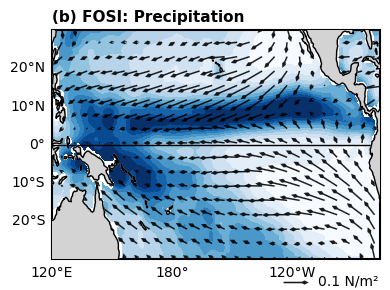

In [8]:
fig, ax = plt.subplots(figsize=(4, 3),
                      subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180, globe=None)})

####### STATICS
ax.add_feature(cfeature.LAND, color='lightgray', zorder=100)
ax.add_feature(cfeature.COASTLINE, linewidth=1., zorder=100)
ax.grid(c='k', linestyle='dashed', alpha=0.2, zorder=4)
ax.set_extent([120, 284, -30, 30], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels={'left': True, 'bottom': True, 'right': False, 'top': False}, 
                  zorder=4, linestyle='--', alpha=0.0)
gl.xlabel_style = {'size': 10, 'color':'k'}  # Longitude labels
gl.ylabel_style = {'size': 10, 'color':'k'}  # Latitude labels
ax.axhline(y=0, color='k', linestyle='-', linewidth=1, zorder=5)
ax.spines['geo'].set_edgecolor('black')
ax.spines['geo'].set_linewidth(1.5)
ax.set_aspect('auto')

FOSI_PRECT = regridded_PREC_F.isel(time=slice(0, 240)).mean(dim='time').sel(
        lat=slice(-60, 60), 
        lon=slice(120, 295))

# #### CONTOURF AND CONTOUR
contourf_plot = FOSI_PRECT.plot.contourf(
    x='lon', y='lat', cmap='Blues', add_colorbar=False, transform=ccrs.PlateCarree(),
    vmin=0, vmax=1.0e-7, levels=11, alpha=1)

step = 5
step_lon = step
step_lat = step

lon_sub = FOSI_TAUX.lon.values[::5]
lat_sub = FOSI_TAUX.lat.values[::4]
TAUX_sub = FOSI_TAUX.sel(lon=lon_sub, lat=lat_sub).values
TAUY_sub = FOSI_TAUY.sel(lon=lon_sub, lat=lat_sub).values

# Create meshgrid for quiver
lon_grid, lat_grid = np.meshgrid(lon_sub, lat_sub)

# Calculate a good scale automatically
vector_magnitudes = np.sqrt(TAUX_sub**2 + TAUY_sub**2)
median_mag = np.median(vector_magnitudes[~np.isnan(vector_magnitudes)])
scale_value = median_mag * 30  # Adjust multiplier: smaller = bigger arrows

Q = ax.quiver(lon_grid, lat_grid, TAUX_sub, TAUY_sub,
              transform=ccrs.PlateCarree(),
              scale=scale_value,  # Dynamic scaling
              width=0.004,  # Slightly thicker
              headwidth=3,  # Slightly larger head
              headlength=3,
              headaxislength=5,
              color='k',
              edgecolor='k', 
              linewidth=0.1,
              alpha=0.9,  # Slight transparency
              zorder=10)

ax.quiverkey(Q, 0.78, -0.10, 0.1, 
             '0.1 N/m²', 
             labelpos='E',
             coordinates='axes',
             fontproperties={'size': 10, 'weight': 'normal'})

plt.title('(b) FOSI: Precipitation', fontsize=11, fontweight='bold', zorder=12, loc='left')
plt.tight_layout()
plt.show()

In [9]:
ENS_MEMBERS_LIST = [0, 65,  32, 85, 61, 90, 80, 68, 73, 49] 

LENS_PRECT_list = []
for ENS_MEMB in ENS_MEMBERS_LIST:
    PRECT = afuncs.atm_var_ens(ENS_MEMB, 'PRECT')
    PRECT_noland = PRECT.sel(
        lat=slice(-60, 60), 
        lon=slice(120, 295))*landmask

    PRECT_noland_ds = xr.where(PRECT_noland > 0., PRECT_noland, np.nan)
    PRECT_noland_ds_mean = PRECT_noland_ds.isel(time=slice(0, 240)).mean(dim='time')
    LENS_PRECT_list.append(PRECT_noland_ds_mean)

LENS_PRECT = xr.concat(LENS_PRECT_list, dim='ensemble')

In [10]:
ENS_MEMBERS_LIST = [0, 65,  32, 85, 61, 90, 80, 68, 73, 49] 

LENS_TAUX_list = []
LENS_TAUY_list = []

for ENS_MEMB in ENS_MEMBERS_LIST:
    TAUX = afuncs.atm_var_ens(ENS_MEMB, 'TAUX')
    TAUY = afuncs.atm_var_ens(ENS_MEMB, 'TAUY')
    TAUX_noland = TAUX.sel(
        lat=slice(-60, 60), 
        lon=slice(120, 295)).isel(time=slice(0, 240))
    TAUY_noland = TAUY.sel(
        lat=slice(-60, 60), 
        lon=slice(120, 295)).isel(time=slice(0, 240))

    TAUX_noland_ds = TAUX_noland
    TAUY_noland_ds = TAUY_noland
    
    LENS_TAUX_list.append(TAUX_noland_ds)
    LENS_TAUY_list.append(TAUY_noland_ds)

LENS_TAUX = xr.concat(LENS_TAUX_list, dim='ensemble')
LENS_TAUY = xr.concat(LENS_TAUY_list, dim='ensemble')

# Calculate seasonal means for DJF (boreal winter)
LENS_TAUX_DJF = LENS_TAUX.where(LENS_TAUX.time.dt.month.isin([12, 1, 2]), drop=True).mean(dim='time')
LENS_TAUY_DJF = LENS_TAUY.where(LENS_TAUY.time.dt.month.isin([12, 1, 2]), drop=True).mean(dim='time')

# Then use these seasonal datasets in your plot:
TAUX_mean = LENS_TAUX_DJF.mean(dim='ensemble')
TAUY_mean = LENS_TAUY_DJF.mean(dim='ensemble')

LENS_TAUX_DJF_mean = TAUX_mean*-1
LENS_TAUY_DJF_mean = TAUY_mean*-1

LENS_TAUX_mean = LENS_TAUX.mean(dim='time').mean(dim='ensemble')*-1
LENS_TAUY_mean = LENS_TAUY.mean(dim='time').mean(dim='ensemble')*-1

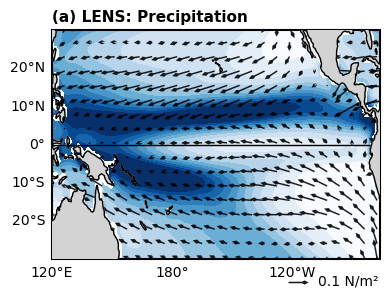

In [14]:
fig, ax = plt.subplots(figsize=(4, 3),
                      subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180, globe=None)})

####### STATICS
ax.add_feature(cfeature.LAND, color='lightgray', zorder=100)
ax.add_feature(cfeature.COASTLINE, linewidth=1., zorder=100)
ax.grid(c='k', linestyle='dashed', alpha=0.2, zorder=4)
ax.set_extent([120, 284, -30, 30], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels={'left': True, 'bottom': True, 'right': False, 'top': False}, 
                  zorder=4, linestyle='--', alpha=0.0)
gl.xlabel_style = {'size': 10, 'color':'k'}  # Longitude labels
gl.ylabel_style = {'size': 10, 'color':'k'}  # Latitude labels
ax.axhline(y=0, color='k', linestyle='-', linewidth=1, zorder=5)
ax.spines['geo'].set_edgecolor('black')
ax.spines['geo'].set_linewidth(1.5)
ax.set_aspect('auto')

contourf_plot = LENS_PRECT.mean(dim='ensemble').plot.contourf(
    x='lon', y='lat', cmap='Blues', add_colorbar=False, transform=ccrs.PlateCarree(),
    vmin=0, vmax=1.0e-7, levels=11, alpha=1)

step_lon = step
step_lat = step

lon_sub = LENS_TAUX_mean.lon.values[::5]
lat_sub = LENS_TAUX_mean.lat.values[::4]
TAUX_sub = LENS_TAUX_mean.sel(lon=lon_sub, lat=lat_sub).values
TAUY_sub = LENS_TAUY_mean.sel(lon=lon_sub, lat=lat_sub).values

# Create meshgrid for quiver
lon_grid, lat_grid = np.meshgrid(lon_sub, lat_sub)

# Calculate a good scale automatically
vector_magnitudes = np.sqrt(TAUX_sub**2 + TAUY_sub**2)
median_mag = np.median(vector_magnitudes[~np.isnan(vector_magnitudes)])
scale_value = median_mag * 30  # Adjust multiplier: smaller = bigger arrows

Q = ax.quiver(lon_grid, lat_grid, TAUX_sub, TAUY_sub,
              transform=ccrs.PlateCarree(),
              scale=scale_value,
              width=0.004,
              headwidth=3,
              headlength=3,
              headaxislength=5,
              color='k',
              edgecolor='k', 
              linewidth=0.1,
              alpha=0.9,
              zorder=10)

ax.quiverkey(Q, 0.78, -0.10, 0.1, 
             '0.1 N/m²', 
             labelpos='E',
             coordinates='axes',
             fontproperties={'size': 10, 'weight': 'normal'})

plt.title('(a) LENS: Precipitation', fontsize=11, fontweight='bold', zorder=12, loc='left')
plt.tight_layout()
plt.show()

In [94]:
diff_PRECT = LENS_PRECT.mean(dim='ensemble') - FOSI_PRECT

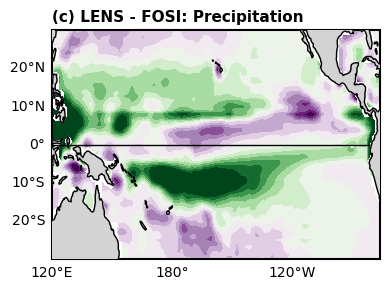

In [101]:
fig, ax = plt.subplots(figsize=(4, 3),
                      subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180, globe=None)})

####### STATICS
ax.add_feature(cfeature.LAND, color='lightgray', zorder=100)
ax.add_feature(cfeature.COASTLINE, linewidth=1., zorder=100)
ax.set_extent([120, 284, -30, 30], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels={'left': True, 'bottom': True, 'right': False, 'top': False}, 
                  zorder=4, linestyle='--', alpha=0.0)
gl.xlabel_style = {'size': 10, 'color':'k'}  # Longitude labels
gl.ylabel_style = {'size': 10, 'color':'k'}  # Latitude labels
ax.axhline(y=0, color='k', linestyle='-', linewidth=1, zorder=5)
ax.spines['geo'].set_edgecolor('black')
ax.spines['geo'].set_linewidth(1.5)
ax.set_aspect('auto')

contourf_plot = diff_PRECT.plot.contourf(
    x='lon', y='lat', cmap='PRGn', add_colorbar=False, transform=ccrs.PlateCarree(),
    vmin=-3.0e-8, vmax=3.0e-8, levels=13, alpha=1)

plt.title('(c) LENS - FOSI: Precipitation', fontsize=11, fontweight='bold', zorder=12, loc='left')
plt.tight_layout()
plt.show()

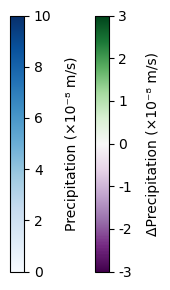

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(1.8, 3))

# Blues colorbar
density_sm1 = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(0, 1e-7))
cbar1 = plt.colorbar(density_sm1, cax=ax1, orientation='vertical')
cbar1.set_label('Precipitation (×10⁻⁸ m/s)', fontsize=10, labelpad=10)
cbar1.set_ticks(np.arange(0, 11, 2) * 1e-8)
cbar1.set_ticklabels(['0', '2', '4', '6', '8', '10'])
cbar1.ax.tick_params(labelsize=10)

# PRGn colorbar  
density_sm2 = plt.cm.ScalarMappable(cmap='PRGn', norm=plt.Normalize(-3e-8, 3e-8))
cbar2 = plt.colorbar(density_sm2, cax=ax2, orientation='vertical')
cbar2.set_label('ΔPrecipitation (×10⁻⁸ m/s)', fontsize=10, labelpad=10)
cbar2.set_ticks(np.arange(-3, 4, 1) * 1e-8)
cbar2.set_ticklabels(['-3', '-2', '-1', '0', '1', '2', '3'])
cbar2.ax.tick_params(labelsize=10)
plt.tight_layout()
plt.show()

#### Row 2: Magnitude of PV (|PV|) on the 20°C isotherm surface for (c) LENS ensemble mean, (d) FOSI, and (e) their difference (LENS minus FOSI), where red indicates larger |PV| in LENS.

In [78]:
time_start = 0; time_end = 240

In [79]:
##### ------------  LENS
##### POTENTIAL VORTICITY

ENS_MEMBERS_LIST = [0, 65,  32, 85, 61, 90, 80, 68, 73, 49] 

file_paths = [f'/glade/derecho/scratch/cassiacai/regridded_PV_{member}.nc' for member in ENS_MEMBERS_LIST]
LENS_PV_all = xr.open_mfdataset(file_paths, combine='nested', concat_dim='ensemble')
LENS_PV_mean = LENS_PV_all.PV.isel(time=slice(time_start,time_end)).isel(TEMP = 2).mean(dim='time').compute()
LENS_PV_1deg = proc_utils.regrid_SMYLE(LENS_PV_mean)

regridder = xe.Regridder(LENS_PV_1deg, CESMLENS_var[:,:], 'nearest_s2d', periodic=True)

regridded_LENS_PV = np.absolute(regridder(LENS_PV_1deg))

In [80]:
##### ------------  FOSI
##### POTENTIAL VORTICITY
FOSI_PV = xr.open_dataset('/glade/derecho/scratch/cassiacai/regridded_PV_FOSI.nc')
FOSI_PV_mean = FOSI_PV.PV.isel(time=slice(time_start,time_end)).isel(TEMP = 2).mean(dim='time').compute()
FOSI_PV_1deg = proc_utils.regrid_SMYLE(FOSI_PV_mean)
regridded_FOSI_PV = np.absolute(regridder(FOSI_PV_1deg))

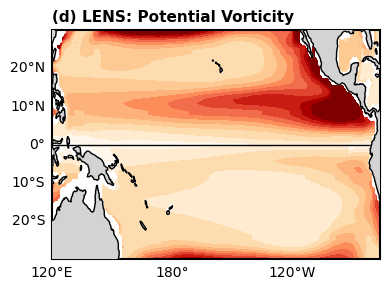

In [16]:
fig, ax = plt.subplots(figsize=(4, 3),
                      subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180, globe=None)})

ax.add_feature(cfeature.LAND, color='lightgray', zorder=100)
ax.add_feature(cfeature.COASTLINE, linewidth=1., zorder=100)
ax.set_extent([120, 284, -30, 30], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels={'left': True, 'bottom': True, 'right': False, 'top': False}, 
                  zorder=4, linestyle='--', alpha=0.0)
gl.xlabel_style = {'size': 10, 'color':'k'}  # Longitude labels
gl.ylabel_style = {'size': 10, 'color':'k'}  # Latitude labels
ax.axhline(y=0, color='k', linestyle='-', linewidth=1, zorder=5)
ax.spines['geo'].set_edgecolor('black')
ax.spines['geo'].set_linewidth(1.5)
ax.set_aspect('auto')

contourf_plot = regridded_LENS_PV.mean(dim='ensemble').sel(lat=slice(-30, 30), lon=slice(120,290)).plot.contourf(
    vmin=0, vmax=2e-11, levels=11,
    cmap='OrRd', transform=ccrs.PlateCarree(), add_colorbar=False)

plt.title('')
plt.title('(d) LENS: Potential Vorticity', fontsize=11, fontweight='bold', zorder=12, loc='left')
plt.tight_layout()
plt.show()

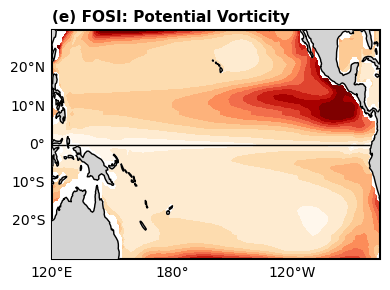

In [17]:
fig, ax = plt.subplots(figsize=(4, 3),
                      subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180, globe=None)})

ax.add_feature(cfeature.LAND, color='lightgray', zorder=100)
ax.add_feature(cfeature.COASTLINE, linewidth=1., zorder=100)
ax.set_extent([120, 284, -30, 30], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels={'left': True, 'bottom': True, 'right': False, 'top': False}, 
                  zorder=4, linestyle='--', alpha=0.0)
gl.xlabel_style = {'size': 10, 'color':'k'}  # Longitude labels
gl.ylabel_style = {'size': 10, 'color':'k'}  # Latitude labels
ax.axhline(y=0, color='k', linestyle='-', linewidth=1, zorder=5)
ax.spines['geo'].set_edgecolor('black')
ax.spines['geo'].set_linewidth(1.5)
ax.set_aspect('auto')

contourf_plot = regridded_FOSI_PV.sel(lat=slice(-30, 30), lon=slice(120,290)).plot.contourf(
    vmin=0, vmax=2e-11, levels=11,
    cmap='OrRd', transform=ccrs.PlateCarree(), add_colorbar=False)

plt.title('')
plt.title('(e) FOSI: Potential Vorticity', fontsize=11, fontweight='bold', zorder=12, loc='left')
plt.tight_layout()
plt.show()

In [18]:
diff_PV = regridded_LENS_PV.mean(dim='ensemble') - regridded_FOSI_PV

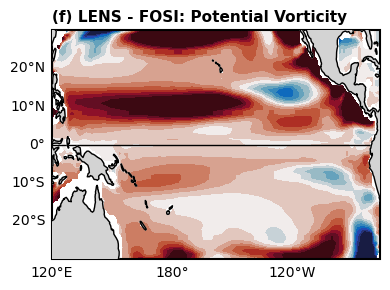

In [19]:
fig, ax = plt.subplots(figsize=(4, 3),
                      subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180, globe=None)})

ax.add_feature(cfeature.LAND, color='lightgray', zorder=100)
ax.add_feature(cfeature.COASTLINE, linewidth=1., zorder=100)
ax.set_extent([120, 284, -30, 30], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels={'left': True, 'bottom': True, 'right': False, 'top': False}, 
                  zorder=4, linestyle='--', alpha=0.0)
gl.xlabel_style = {'size': 10, 'color':'k'}  # Longitude labels
gl.ylabel_style = {'size': 10, 'color':'k'}  # Latitude labels
ax.axhline(y=0, color='k', linestyle='-', linewidth=1, zorder=5)
ax.spines['geo'].set_edgecolor('black')
ax.spines['geo'].set_linewidth(1.5)
ax.set_aspect('auto')

contourf_plot = diff_PV.sel(lat=slice(-40, 40), lon=slice(120,290)).plot.contourf(
    vmin=-0.3e-11, vmax=0.3e-11, levels=16,
    cmap=cmocean.cm.balance,transform=ccrs.PlateCarree(), add_colorbar=False)

plt.title('')
plt.title('(f) LENS - FOSI: Potential Vorticity', fontsize=11, fontweight='bold', zorder=12, loc='left')
plt.tight_layout()
plt.show()

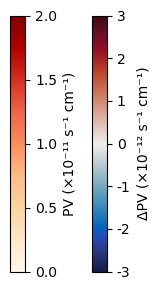

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(1.7, 3))

# Blues colorbar
density_sm1 = plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(0, 2e-11))
cbar1 = plt.colorbar(density_sm1, cax=ax1, orientation='vertical')
cbar1.set_label('PV (×10⁻¹¹ s⁻¹ cm⁻¹)', fontsize=10)
tick_values1 = np.arange(0, 2.1, 0.5)  # 0, 0.5, 1.0, 1.5, 2.0
cbar1.set_ticks(tick_values1 * 1e-11)
cbar1.set_ticklabels([f'{x:.1f}' for x in tick_values1])
cbar1.ax.tick_params(labelsize=10)

# Balance colorbar  
density_sm2 = plt.cm.ScalarMappable(cmap=cmocean.cm.balance, norm=plt.Normalize(-0.3e-11, 0.3e-11))
cbar2 = plt.colorbar(density_sm2, cax=ax2, orientation='vertical')
cbar2.set_label('ΔPV (×10⁻¹² s⁻¹ cm⁻¹)', fontsize=10)
tick_values2 = np.arange(-3, 3.1, 1)  # -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3
cbar2.set_ticks(tick_values2 * 1e-12)
cbar2.set_ticklabels([f'{x:.0f}' for x in tick_values2])
cbar2.ax.tick_params(labelsize=10)

plt.tight_layout()
plt.show()

#### Row 3: Zonal-mean |PV| profile (averaged XX°E–XX°W) for (f) LENS and (g) FOSI, highlighting the vertical structure of the subtropical PV maxima

In [26]:
%%time
ENS_MEMB = 0
LENS_PV = afuncs.ocn_var_ens(ENS_MEMB, 'PV').isel(z_t=slice(0, 27))[:,:, 72:303,140:293].isel(time=slice(0, 240)).compute()

CPU times: user 16.2 s, sys: 932 ms, total: 17.2 s
Wall time: 41.3 s


In [16]:
ENS_MEMBERS_LIST = [0, 65,  32, 85, 61, 90, 80, 68, 73, 49] 

LENS_PV_list = []
for ENS_MEMB in ENS_MEMBERS_LIST:
    print(ENS_MEMB)
    LENS_PV = afuncs.ocn_var_ens(ENS_MEMB, 'PV').isel(z_t=slice(0, 27))[:,:, 72:303,140:293].isel(time=slice(0, 240)).compute()
    
    LENS_PV_list.append(LENS_PV)

LENS_PV_combine = xr.concat(LENS_PV_list, dim='ensemble')

0
65
32
85
61
90
80
68
73
49


In [15]:
LENS_TEMP_list = []
for ENS_MEMB in ENS_MEMBERS_LIST:
    print(ENS_MEMB)
    LENS_TEMP = afuncs.ocn_var_ens(ENS_MEMB, 'TEMP').isel(z_t=slice(0, 27))[:,:, 72:303,140:293].isel(time=slice(0, 240)).compute()
    
    LENS_TEMP_list.append(LENS_TEMP)

LENS_TEMP_combine = xr.concat(LENS_TEMP_list, dim='ensemble')

0
65
32
85
61
90
80
68
73
49


In [18]:
LENS_PV_ens_mean = LENS_PV_combine.mean(dim='ensemble')
LENS_TEMP_ens_mean = LENS_TEMP_combine.mean(dim='ensemble')

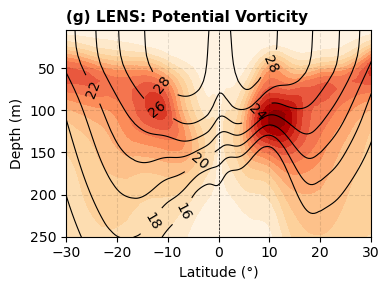

In [33]:
plt.figure(figsize=(4,3))

# Filled contour for PV
cf = plt.contourf(
    LENS_PV_ens_mean.mean(dim='time').ULAT.mean(dim='nlon'), 
    LENS_PV_ens_mean.mean(dim='time').z_t/100, 
    np.abs(LENS_PV_ens_mean.mean(dim='time').isel(nlon=slice(37, 109)).mean(dim='nlon')), 
    cmap='OrRd',
    levels=np.linspace(0, 1.3e-11, 14)
)

cs = plt.contour(
    LENS_PV_ens_mean.mean(dim='time').ULAT.mean(dim='nlon'), 
    LENS_PV_ens_mean.mean(dim='time').z_t/100, 
    LENS_TEMP_ens_mean.mean(dim='time').isel(nlon=slice(37, 109)).mean(dim='nlon'), 
    levels=np.asarray([16, 18, 20, 22, 24, 26, 28]),
    colors='k',
    linewidths=0.8
)

# Add contour labels
plt.clabel(cs, inline=True, fontsize=10, fmt='%.0f')

plt.grid(c='k', alpha=0.1, linestyle='dashed')
plt.axvline(x=0, c='k', linestyle='dashed', linewidth=0.5)
plt.ylim(250, 5)
plt.xlim(-30, 30)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('Latitude (°)', fontsize=10)
plt.ylabel('Depth (m)', fontsize=10)
plt.title('(g) LENS: Potential Vorticity', fontsize=11, fontweight='bold', zorder=12, loc='left')
plt.tight_layout()
plt.show()

In [5]:
field = 'PV'
fpath = '/glade/campaign/cesm/development/espwg/SMYLE/initial_conditions/SMYLE-FOSI/ocn/proc/tseries/month_1/'
fname = f'g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.SMYLE.005.pop.h.{field}.030601-036812.nc'
ds_smyle_fosi_PV = xr.open_dataset(fpath+fname)[field].isel(z_t = slice(0,27))[:,:, 72:303,140:293].compute()
ds_smyle_fosi_PV['time'] = fosi_montime_vals

In [6]:
field = 'TEMP'
fpath = '/glade/campaign/cesm/development/espwg/SMYLE/initial_conditions/SMYLE-FOSI/ocn/proc/tseries/month_1/'
fname = f'g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.SMYLE.005.pop.h.{field}.030601-036812.nc'
ds_smyle_fosi_TEMP = xr.open_dataset(fpath+fname)[field].isel(z_t = slice(0,27))[:,:, 72:303,140:293].compute()
ds_smyle_fosi_TEMP['time'] = fosi_montime_vals

In [7]:
FOSI_PV_mean = ds_smyle_fosi_PV.isel(time=slice(0, 240)).mean(dim='time')
FOSI_TEMP_mean = ds_smyle_fosi_TEMP.isel(time=slice(0, 240)).mean(dim='time')

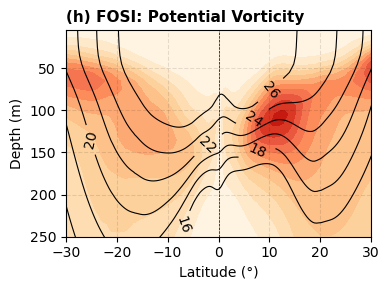

In [10]:
ds_smyle_fosi_PV.isel(time=slice(0, 240)).mean(dim='time')

plt.figure(figsize=(4,3))
plt.contourf(
    FOSI_PV_mean.ULAT.mean(dim='nlon'), 
    FOSI_PV_mean.z_t/100, 
    np.abs(FOSI_PV_mean.isel(nlon=slice(37, 109)).mean(dim='nlon')), cmap='OrRd',levels=np.linspace(0, 1.3e-11, 14))

cs = plt.contour(
    FOSI_TEMP_mean.ULAT.mean(dim='nlon'), 
    FOSI_TEMP_mean.z_t/100, 
    FOSI_TEMP_mean.isel(nlon=slice(37, 109)).mean(dim='nlon'), 
    levels=np.asarray([16, 18, 20, 22, 24, 26, 28]),
    colors='k',
    linewidths=0.8
)

# Add contour labels
plt.clabel(cs, inline=True, fontsize=10, fmt='%.0f')

plt.grid(c='k', alpha=0.1, linestyle='dashed')
plt.axvline(x=0, c='k', linestyle='dashed', linewidth=0.5)
plt.ylim(250, 5)
plt.xlim(-30, 30)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('Latitude (°)', fontsize=10)
plt.ylabel('Depth (m)', fontsize=10)
plt.title('(h) FOSI: Potential Vorticity', fontsize=11, fontweight='bold', zorder=12, loc='left')
plt.tight_layout()
plt.show()

In [42]:
diff_PV_zonal = np.abs(LENS_PV.mean(dim='time')) - np.abs(FOSI_PV_mean)

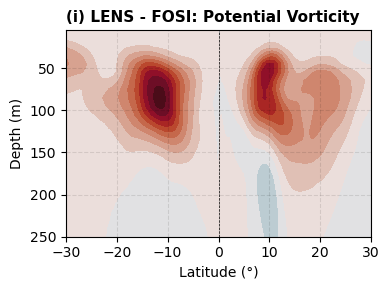

In [61]:
plt.figure(figsize=(4,3))
plt.contourf(
    FOSI_PV_mean.ULAT.mean(dim='nlon'), 
    FOSI_PV_mean.z_t/100, 
    diff_PV_zonal.isel(nlon=slice(37, 109)).mean(dim='nlon'), cmap=cmocean.cm.balance,levels=np.linspace(-0.5e-11, 0.5e-11,21))
plt.grid(c='k', alpha=0.1, linestyle='dashed')
plt.axvline(x=0, c='k', linestyle='dashed', linewidth=0.5)
plt.ylim(250, 5)
plt.xlim(-30, 30)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('Latitude (°)', fontsize=10)
plt.ylabel('Depth (m)', fontsize=10)
plt.title('(i) LENS - FOSI: Potential Vorticity', fontsize=11, fontweight='bold', zorder=12, loc='left')
plt.tight_layout()
plt.show()

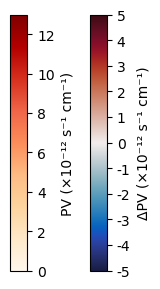

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(1.7, 3))

# Blues colorbar
density_sm1 = plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(0, 13e-12))
cbar1 = plt.colorbar(density_sm1, cax=ax1, orientation='vertical')
cbar1.set_label('PV (×10⁻¹² s⁻¹ cm⁻¹)', fontsize=10)
tick_values1 = np.arange(0, 14, 2)  # 0, 0.5, 1.0, 1.5, 2.0
cbar1.set_ticks(tick_values1 * 1e-12)
cbar1.set_ticklabels([f'{x:.0f}' for x in tick_values1])
cbar1.ax.tick_params(labelsize=10)

# Balance colorbar  
density_sm2 = plt.cm.ScalarMappable(cmap=cmocean.cm.balance, norm=plt.Normalize(-5e-12, 5e-12))
cbar2 = plt.colorbar(density_sm2, cax=ax2, orientation='vertical')
cbar2.set_label('ΔPV (×10⁻¹² s⁻¹ cm⁻¹)', fontsize=10)
tick_values2 = np.arange(-5, 5.1, 1)  # -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3
cbar2.set_ticks(tick_values2 * 1e-12)
cbar2.set_ticklabels([f'{x:.0f}' for x in tick_values2])
cbar2.ax.tick_params(labelsize=10)

plt.tight_layout()
plt.show()

### Figure 2 (top row)

South Pacific is found in a different notebook.

#### Particle trajectories (lines) and pathway density of particle trajectories (color fill) over 1958-1978, comparing the 10-member LENS mean and the FOSI simulation. Initial particle positions in the South Pacific (30°S – 40°S, 220°E – 240°E) and North Pacific (38°–45°N, 140°–210°E) are marked with purple dots. (a, e) LENS simulation for the (a) North and (e) South Pacific. 

In [70]:
# LENS --- North Pacific
ENS_MEMBERS_LIST = [0, 65,  32, 85, 61, 90, 80, 68, 73, 49] 
INIT_DEPTH = 50

region_indx_list = []; da_list = []
lon_trunc_list = []; lat_trunc_list = []; z_trunc_list = []

for ENS_MEMB in ENS_MEMBERS_LIST:
    print(ENS_MEMB)
    file_path = '/glade/derecho/scratch/cassiacai/particle_trajectories/particle_trajectories_lens{}_NH_startingat{}m_1958_1977.zarr'.format(
        ENS_MEMB, INIT_DEPTH)

    lens_pt = xr.open_zarr(file_path)
    l_time, l_lon, l_lat, l_z = stcfuncs.compute_data(lens_pt)

    ### NORTH PACIFIC
    da_l, region_idx_l,lon_trunc_l,lat_trunc_l, z_trunc_l = stcfuncs.calc_density(
       lon_data=l_lon, lat_data=l_lat, z_data=l_z, 
        lat_min=38, lat_max=45, lon_min=140, lon_max=210,
        timestart=0, timeend=244)
    
    region_indx_list.append(region_idx_l)
    lon_trunc_list.append(lon_trunc_l)
    lat_trunc_list.append(lat_trunc_l)
    z_trunc_list.append(z_trunc_l)
    da_list.append(da_l)

0
65
32
85
61
90
80
68
73
49


In [71]:
da_xr = xr.concat(da_list, dim='ensemble')

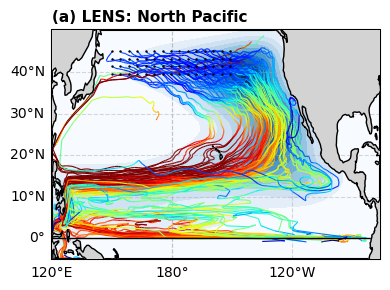

In [72]:
da = da_xr.mean(dim='ensemble')
lon_data= lon_trunc_list[2][ :, 0:244]
lat_data= lat_trunc_list[2][:, 0:244]
z_data= z_trunc_list[2][:, 0:244]
region_idx = region_indx_list[0]

fig, ax = plt.subplots(figsize=(4, 3),
                      subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180, globe=None)})
####### STATICS
ax.add_feature(cfeature.LAND, color='lightgray', zorder=100)
ax.add_feature(cfeature.COASTLINE, linewidth=1., zorder=100)
ax.grid(c='k', linestyle='dashed', alpha=0.2, zorder=4)
# ax.set_extent([120, 284, -50, 5], crs=ccrs.PlateCarree())
ax.set_extent([120, 284, -5, 50], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels={'left': True, 'bottom': True, 'right': False, 'top': False}, 
                  zorder=4, linestyle='--', alpha=0.5)
gl.xlabel_style = {'size': 10, 'color':'k'}  # Longitude labels
gl.ylabel_style = {'size': 10, 'color':'k'}  # Latitude labels
ax.axhline(y=0, color='k', linestyle='-', linewidth=1, zorder=5)
ax.spines['geo'].set_edgecolor('black')
ax.spines['geo'].set_linewidth(1.5)
ax.set_aspect('auto')

ax.scatter(lon_data[region_idx, 0], lat_data[region_idx, 0], 
           s=0.5, c='k', marker='o', edgecolor='k', zorder=100,transform=ccrs.PlateCarree())

# #### CONTOURF AND CONTOUR
contourf_plot = da.plot.contourf(
    x='lon', y='lat', cmap='Blues', add_colorbar=False, transform=ccrs.PlateCarree(),
    levels=11, vmax=60e-5, vmin=0, alpha=1) # 60 for SH

#### TRAJECTORIES
for i in region_indx_list[2][::1]:
    lon = lon_trunc_list[2].isel(trajectory=i).values
    lat = lat_trunc_list[2].isel(trajectory=i).values
    depth = z_trunc_list[2].isel(trajectory=i).values
    points = np.array([lon, lat]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = mcollections.LineCollection(
            segments, cmap='jet', norm=plt.Normalize(0, 25000), 
            linewidth=.8, alpha=1, transform=ccrs.PlateCarree())
    lc.set_array(depth[:-1])
    ax.add_collection(lc)

plt.title('(a) LENS: North Pacific', fontsize=11, fontweight='bold', zorder=12, loc='left')
plt.tight_layout()
plt.show()

#### (b, f) As in (a, e), but for the FOSI simulation. 

In [73]:
INIT_DEPTH = 50

file_path = '/glade/derecho/scratch/cassiacai/particle_trajectories/particle_trajectories_fosi_NH_startingat{}m_1958_1977.zarr'.format(
    INIT_DEPTH)

fosi_pt = xr.open_zarr(file_path)
f_time, f_lon, f_lat, f_z = stcfuncs.compute_data(fosi_pt)

#### NORTH PACIFIC
da_f, region_idx_f, lon_trunc_f,lat_trunc_f, z_trunc_f = stcfuncs.calc_density(
   lon_data=f_lon, lat_data=f_lat, z_data=f_z, 
    lat_min=38, lat_max=45, 
    lon_min=140, lon_max=210,
    timestart=0, timeend=244)

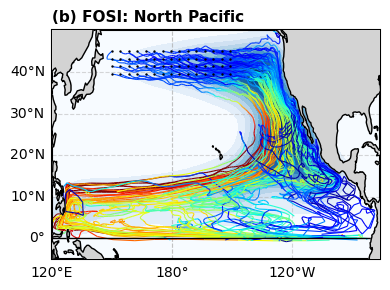

In [74]:
da = da_f
lon_data= lon_trunc_f[:, 0:244]
lat_data= lat_trunc_f[:, 0:244]
z_data= z_trunc_f[:, 0:244]
region_idx = region_idx_f

fig, ax = plt.subplots(figsize=(4, 3),
                      subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180, globe=None)})
ax.add_feature(cfeature.LAND, color='lightgray', zorder=100)
ax.add_feature(cfeature.COASTLINE, linewidth=1., zorder=100)
ax.grid(c='k', linestyle='dashed', alpha=0.2, zorder=4)
# ax.set_extent([120, 284, -50, 5], crs=ccrs.PlateCarree())
ax.set_extent([120, 284, -5, 50], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels={'left': True, 'bottom': True, 'right': False, 'top': False}, 
                  zorder=4, linestyle='--', alpha=0.5)
gl.xlabel_style = {'size': 10, 'color':'k'}  # Longitude labels
gl.ylabel_style = {'size': 10, 'color':'k'}  # Latitude labels
ax.axhline(y=0, color='k', linestyle='-', linewidth=1, zorder=5)
ax.spines['geo'].set_edgecolor('black')
ax.spines['geo'].set_linewidth(1.5)
ax.set_aspect('auto')

ax.scatter(lon_data[region_idx, 0], lat_data[region_idx, 0], 
           s=0.5, c='k', marker='o', edgecolor='k', zorder=100,transform=ccrs.PlateCarree())

contourf_plot = da.plot.contourf(
    x='lon', y='lat', cmap='Blues', add_colorbar=False, transform=ccrs.PlateCarree(),
    levels=11, vmax=60e-5, vmin=0, alpha=1) # 60 for SH

for i in region_idx[::1]:
    lon = lon_data.isel(trajectory=i).values
    lat = lat_data.isel(trajectory=i).values
    depth = z_data.isel(trajectory=i).values
    points = np.array([lon, lat]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = mcollections.LineCollection(
            segments, cmap='jet', norm=plt.Normalize(0, 25000), 
            linewidth=0.8, alpha=1, transform=ccrs.PlateCarree())
    lc.set_array(depth[:-1])
    ax.add_collection(lc)

plt.title('(b) FOSI: North Pacific', fontsize=11, fontweight='bold', zorder=12, loc='left')
plt.tight_layout()
plt.show()

#### (c, g) Difference in pathway density (LENS minus FOSI) over the full 20-year period for the (c) North and (g) South Pacific.

In [75]:
da_diff_xr = da_xr - da_f
da_diff_xr.mean(dim=('y','x')).argmin()

<xarray.DataArray 'density' ()> Size: 8B
array(2)

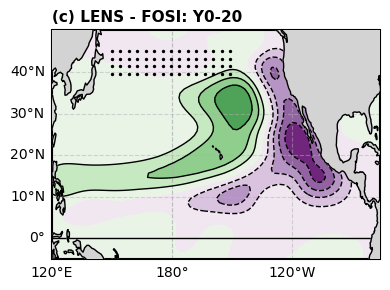

In [76]:
da_diff = da_xr.mean(dim='ensemble') - da_f

fig, ax = plt.subplots(figsize=(4, 3),
                      subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180, globe=None)})
ax.add_feature(cfeature.LAND, color='lightgray', zorder=100)
ax.add_feature(cfeature.COASTLINE, linewidth=1., zorder=100)
ax.grid(c='k', linestyle='dashed', alpha=0.2, zorder=4)
ax.set_extent([120, 284, -5, 50], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels={'left': True, 'bottom': True, 'right': False, 'top': False}, 
                  zorder=4, linestyle='--', alpha=0.5)
gl.xlabel_style = {'size': 10, 'color':'k'}  # Longitude labels
gl.ylabel_style = {'size': 10, 'color':'k'}  # Latitude labels
ax.spines['geo'].set_edgecolor('black')
ax.spines['geo'].set_linewidth(1.5)
ax.set_aspect('auto')
ax.axhline(y=0, color='k', linestyle='-', linewidth=1, zorder=5)

ax.scatter(lon_trunc_f[region_idx, 0][::1], lat_trunc_f[region_idx, 0][::1], 
           s=2, c='k', marker='o', edgecolor='k', zorder=200,transform=ccrs.PlateCarree())

# # #### CONTOURF AND CONTOUR
contourf_plot = da_diff.plot.contourf(
    x='lon', y='lat', cmap='PRGn', add_colorbar=False, transform=ccrs.PlateCarree(),
    alpha=1, vmin=-30e-5, vmax=30e-5, levels=13)

# CONTOUR LINES
da_diff.plot.contour(
    x='lon', y='lat', transform=ccrs.PlateCarree(), colors='k', linewidths=1,
    levels=[-20e-5, -15e-5, -10e-5, -5e-5, 5e-5, 10e-5, 15e-5, 20e-5], alpha=1)

plt.title('(c) LENS - FOSI: Y0-20', fontsize=11, fontweight='bold', zorder=12, loc='left')
plt.tight_layout()
plt.show()

In [94]:
# LENS --- North Pacific
ENS_MEMBERS_LIST = [0, 65,  32, 85, 61, 90, 80, 68, 73, 49] 
INIT_DEPTH = 50

region_indx_list = []; da_list = []
lon_trunc_list = []; lat_trunc_list = []; z_trunc_list = []

for ENS_MEMB in ENS_MEMBERS_LIST:
    print(ENS_MEMB)
    file_path = '/glade/derecho/scratch/cassiacai/particle_trajectories/particle_trajectories_lens{}_NH_startingat{}m_1958_1977.zarr'.format(
        ENS_MEMB, INIT_DEPTH)

    lens_pt = xr.open_zarr(file_path)
    l_time, l_lon, l_lat, l_z = stcfuncs.compute_data(lens_pt)

    ### NORTH PACIFIC
    da_l, region_idx_l,lon_trunc_l,lat_trunc_l, z_trunc_l = stcfuncs.calc_density(
       lon_data=l_lon, lat_data=l_lat, z_data=l_z, 
        lat_min=38, lat_max=45, lon_min=140, lon_max=210,
        timestart=244-61, timeend=244)
    
    region_indx_list.append(region_idx_l)
    lon_trunc_list.append(lon_trunc_l)
    lat_trunc_list.append(lat_trunc_l)
    z_trunc_list.append(z_trunc_l)
    da_list.append(da_l)

0
65
32
85
61
90
80
68
73
49


In [95]:
da_xr = xr.concat(da_list, dim='ensemble')

In [96]:
INIT_DEPTH = 50

file_path = '/glade/derecho/scratch/cassiacai/particle_trajectories/particle_trajectories_fosi_NH_startingat{}m_1958_1977.zarr'.format(
    INIT_DEPTH)

fosi_pt = xr.open_zarr(file_path)
f_time, f_lon, f_lat, f_z = stcfuncs.compute_data(fosi_pt)

#### NORTH PACIFIC
da_f, region_idx_f, lon_trunc_f,lat_trunc_f, z_trunc_f = stcfuncs.calc_density(
   lon_data=f_lon, lat_data=f_lat, z_data=f_z, 
    lat_min=38, lat_max=45, 
    lon_min=140, lon_max=210,
    timestart=244-61, timeend=244)

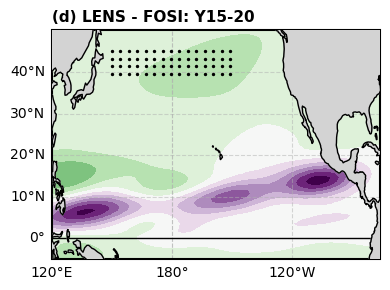

In [61]:
da_diff = da_xr.mean(dim='ensemble') - da_f

fig, ax = plt.subplots(figsize=(4, 3),
                      subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180, globe=None)})
ax.add_feature(cfeature.LAND, color='lightgray', zorder=100)
ax.add_feature(cfeature.COASTLINE, linewidth=1., zorder=100)
ax.grid(c='k', linestyle='dashed', alpha=0.2, zorder=4)
ax.set_extent([120, 284, -5, 50], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels={'left': True, 'bottom': True, 'right': False, 'top': False}, 
                  zorder=4, linestyle='--', alpha=0.5)
gl.xlabel_style = {'size': 10, 'color':'k'}  # Longitude labels
gl.ylabel_style = {'size': 10, 'color':'k'}  # Latitude labels
ax.spines['geo'].set_edgecolor('black')
ax.spines['geo'].set_linewidth(1.5)
ax.set_aspect('auto')
ax.axhline(y=0, color='k', linestyle='-', linewidth=1, zorder=5)

ax.scatter(lon_trunc_f[region_idx, 0][::1], lat_trunc_f[region_idx, 0][::1], 
           s=2, c='k', marker='o', edgecolor='k', zorder=200,transform=ccrs.PlateCarree())

# # #### CONTOURF AND CONTOUR
contourf_plot = da_diff.plot.contourf(
    x='lon', y='lat', cmap='PRGn', add_colorbar=False, transform=ccrs.PlateCarree(),
    alpha=1, vmin=-30e-5, vmax=30e-5, levels=13)

plt.title('(d) LENS - FOSI: Y15-20', fontsize=11, fontweight='bold', zorder=12, loc='left')
plt.tight_layout()
plt.show()

#### (d, h) As in (c, g), but for the final 5 years only. Cross-hatching indicates regions where the potential vorticity (PV) difference exceeds a threshold, highlighting a dynamical barrier present in LENS but not in FOSI. The PV thresholds used for hatching correspond to one standard deviation of the mean magnitude of PV difference in the respective subtropical regions, highlighting the barriers. Thresholds are >XX s-1 cm-1 for the North Pacific (d) and >XX s-1 cm-1 for the South Pacific (h).

In [81]:
diff_PV = regridded_LENS_PV - regridded_FOSI_PV

In [92]:
diff_PV_bin_prog_std = diff_PV.sel(lat=slice(-40, 40), lon=slice(120,290))
diff_PV_bin_prog = diff_PV.mean(dim='ensemble').sel(lat=slice(-40, 40), lon=slice(120,290))
diff_SH_PV_binarize = xr.where(diff_PV_bin_prog > diff_PV_bin_prog_std.std()/10, 1., 0.)
diff_NH_PV_binarize = xr.where(diff_PV_bin_prog > diff_PV_bin_prog_std.std()/2, 1., 0.)

In [115]:
print(diff_PV_bin_prog_std.std()/10)
print(diff_PV_bin_prog_std.std()/2)

<xarray.DataArray ()> Size: 8B
array(2.65970127e-13)
Coordinates:
    TEMP     float64 8B 20.0
<xarray.DataArray ()> Size: 8B
array(1.32985064e-12)
Coordinates:
    TEMP     float64 8B 20.0


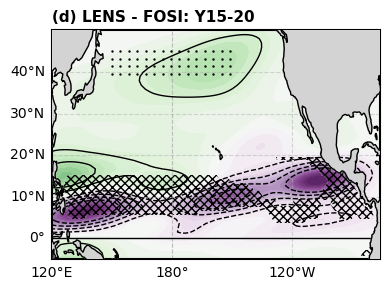

In [99]:
fosi_nan = da_f.fillna(0)
lens_nan = da_xr.mean(dim='ensemble').fillna(0)

diff = lens_nan - fosi_nan

fig, ax = plt.subplots(figsize=(4, 3), 
                      subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180, globe=None)})
####### STATICS
ax.add_feature(cfeature.LAND, color='lightgray', zorder=100)
ax.add_feature(cfeature.COASTLINE, linewidth=1., zorder=100)
ax.grid(c='k', linestyle='dashed', alpha=0.2, zorder=4)
ax.set_extent([120, 284, -5, 50], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels={'left': True, 'bottom': True, 'right': False, 'top': False}, 
                  zorder=4, linestyle='--', alpha=0.5)
gl.xlabel_style = {'size': 10, 'color':'k'}  # Longitude labels
gl.ylabel_style = {'size': 10, 'color':'k'}  # Latitude labels
ax.axhline(y=0, color='k', linestyle='-', linewidth=1, zorder=5)
ax.spines['geo'].set_edgecolor('black')
ax.spines['geo'].set_linewidth(1.5)
ax.set_aspect('auto')  # Override the equal aspect ratio

####### DENSITY CONTOUR
contourf_plot = diff.plot.contourf(
    x='lon', y='lat', cmap='PRGn', add_colorbar=False, transform=ccrs.PlateCarree(),
    levels=40, 
    vmax=30e-5, 
    vmin=-30e-5, alpha=1
)

# regridded_LENS_PV.isel(ensemble=ENS_IND).sel(lat=slice(-25, 25), lon=slice(120,290)).plot.contour(cmap='cyan',
#     levels=[0.4e-11, 0.45e-11, 0.5e-11],transform=ccrs.PlateCarree(), add_colorbar=False, zorder=400)

# CONTOUR LINES
diff.plot.contour(
    x='lon', y='lat', transform=ccrs.PlateCarree(), colors='k', linewidths=1,
    levels=[-20e-5, -15e-5, -10e-5, -5e-5, 5e-5, 10e-5, 15e-5, 20e-5], alpha=1)

plt.title('(h)', fontsize=12, fontweight='bold', zorder=12, loc='left')

# diff_PV_binarize.sel(lat=slice(-15, 0), lon=slice(120,240)).plot.contourf(
#     cmap='Grays',transform=ccrs.PlateCarree(), add_colorbar=False, alpha=0.2)
# cs = diff_PV_binarize.sel(lat=slice(-15, 5), lon=slice(120,290)).plot.contourf(
#     transform=ccrs.PlateCarree(), add_colorbar=False, alpha=0.1,
#     hatches=['','xxxx', ''],  # Slanted lines pattern
#     colors='white', levels=[0, 0.5, 1.5]
# )

cs = diff_NH_PV_binarize.sel(lat=slice(-5, 20), lon=slice(120,290)).plot.contourf(
    transform=ccrs.PlateCarree(), add_colorbar=False, alpha=0.15,
    hatches=['','xxxx', ''],
    colors='white', levels=[0, 0.5, 1.5]
)

ax.scatter(lon_data[region_idx, 0], lat_data[region_idx, 0], 
           s=0.5, c='k', marker='o', edgecolor='k', zorder=100,transform=ccrs.PlateCarree())

plt.title('')
plt.title('(d) LENS - FOSI: Y15-20', fontsize=11, fontweight='bold', zorder=12, loc='left')
plt.tight_layout()
plt.show()

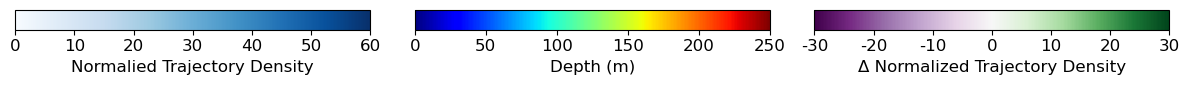

In [113]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 0.95))

# Blues colorbar
density_sm1 = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(0, 60e-5))
cbar1 = plt.colorbar(density_sm1, cax=ax1, orientation='horizontal')
cbar1.set_label('Normalied Trajectory Density', fontsize=12)
tick_values1 = np.arange(0, 65, 10)  # 0, 0.5, 1.0, 1.5, 2.0
cbar1.set_ticks(tick_values1 * 1e-5)
cbar1.set_ticklabels([f'{x:.0f}' for x in tick_values1])
cbar1.ax.tick_params(labelsize=12)

# Balance colorbar  
density_sm2 = plt.cm.ScalarMappable(cmap='jet', norm=plt.Normalize(0, 250))
cbar2 = plt.colorbar(density_sm2, cax=ax2, orientation='horizontal')
cbar2.set_label('Depth (m)', fontsize=12)
tick_values2 = np.arange(0, 260, 50)  # -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3
cbar2.set_ticks(tick_values2 * 1)
cbar2.set_ticklabels([f'{x:.0f}' for x in tick_values2])
cbar2.ax.tick_params(labelsize=12)

# Balance colorbar  
density_sm2 = plt.cm.ScalarMappable(cmap='PRGn', norm=plt.Normalize(-30e-5, 30e-5))
cbar2 = plt.colorbar(density_sm2, cax=ax3, orientation='horizontal')
cbar2.set_label('Δ Normalized Trajectory Density', fontsize=12)
tick_values2 = np.arange(-30, 35, 10)  # -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3
cbar2.set_ticks(tick_values2 * 1e-5)
cbar2.set_ticklabels([f'{x:.0f}' for x in tick_values2])
cbar2.ax.tick_params(labelsize=12)

plt.tight_layout()
plt.show()

### Figure 3

#### (c) Still have to do the colorbar

In [12]:
# LENS --- EQ THERMOCLINE
ENS_MEMBERS_LIST = [0, 65,  32, 85, 61, 90, 80, 68, 73, 49] #[0, 65,  32, 85, 61, 90, 80, 68, 73, 49] 

region_indx_list = []; da_list = []
lon_trunc_list = []; lat_trunc_list = []; z_trunc_list = []

for ENS_MEMB in ENS_MEMBERS_LIST:
    print(ENS_MEMB)
    file_path = "/glade/derecho/scratch/cassiacai/particle_trajectories/particle_trajectories_lens{}_EQ_startingat5m_1958_1977.zarr".format(
        ENS_MEMB)

    lens_pt = xr.open_zarr(file_path)
    l_time, l_lon, l_lat, l_z = stcfuncs.compute_data(lens_pt)

    ### NORTH PACIFIC
    da_l, region_idx_l,lon_trunc_l,lat_trunc_l, z_trunc_l = stcfuncs.calc_density_eqthermocline(
       lon_data=l_lon, lat_data=l_lat, z_data=l_z, 
        lat_min=-1, lat_max=1, lon_min=140, lon_max=280,
        timestart=0, timeend=244)
    
    region_indx_list.append(region_idx_l)
    lon_trunc_list.append(lon_trunc_l)
    lat_trunc_list.append(lat_trunc_l)
    z_trunc_list.append(z_trunc_l)
    da_list.append(da_l)

0
65
32
85
61
90
80
68
73
49


In [13]:
da_xr = xr.concat(da_list, dim='ensemble')

In [32]:
da_diff = da_xr - da_f
da_diff.mean(dim=('y','x')).argmin()

<xarray.DataArray 'density' ()> Size: 8B
array(0)

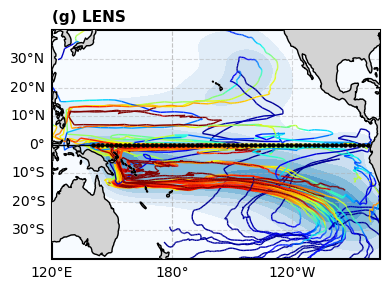

In [34]:
da = da_xr.mean(dim='ensemble')
lon_data= lon_trunc_list[0][ :, 0:244]
lat_data= lat_trunc_list[0][:, 0:244]
z_data= z_trunc_list[0][:, 0:244]
region_idx = region_indx_list[0]

fig, ax = plt.subplots(figsize=(4, 3),
                      subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180, globe=None)})
####### STATICS
ax.add_feature(cfeature.LAND, color='lightgray', zorder=100)
ax.add_feature(cfeature.COASTLINE, linewidth=1., zorder=100)
ax.grid(c='k', linestyle='dashed', alpha=0.2, zorder=4)
ax.set_extent([120, 284, -40, 40], crs=ccrs.PlateCarree())
# ax.set_extent([120, 284, -5, 50], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels={'left': True, 'bottom': True, 'right': False, 'top': False}, 
                  zorder=4, linestyle='--', alpha=0.5)
gl.xlabel_style = {'size': 10, 'color':'k'}  # Longitude labels
gl.ylabel_style = {'size': 10, 'color':'k'}  # Latitude labels
ax.axhline(y=0, color='k', linestyle='-', linewidth=1, zorder=5)
ax.spines['geo'].set_edgecolor('black')
ax.spines['geo'].set_linewidth(1.5)
ax.set_aspect('auto')

ax.scatter(lon_trunc_list[0][region_idx, 0][::2], lat_trunc_list[0][region_idx, 0][::2], 
           s=5, c='k', marker='o', edgecolor='k', zorder=200,transform=ccrs.PlateCarree())

# #### CONTOURF AND CONTOUR
contourf_plot = da.plot.contourf(
    x='lon', y='lat', cmap='Blues', add_colorbar=False, transform=ccrs.PlateCarree(),
    levels=11, vmax=40e-5, vmin=0, alpha=1) # 60 for SH

#### TRAJECTORIES
for i in region_indx_list[0][::4]:
    lon = lon_trunc_list[0].isel(trajectory=i).values
    lat = lat_trunc_list[0].isel(trajectory=i).values
    depth = z_trunc_list[0].isel(trajectory=i).values
    points = np.array([lon, lat]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = mcollections.LineCollection(
            segments, cmap='jet', norm=plt.Normalize(0, 25000), 
            linewidth=1., alpha=1, transform=ccrs.PlateCarree())
    lc.set_array(depth[:-1])
    ax.add_collection(lc)

# #### COLORBAR
# density_sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(0.5e-5, 80.5e-5))
# density_sm.set_array([])
# density_cbar = plt.colorbar(density_sm, ax=ax, aspect=30, shrink=0.8, pad=0.1, orientation='horizontal')
# density_cbar.set_label('Normalized Trajectory Density', fontsize=11)
# tick_values = np.arange(0, 90, 20)  # This gives 5, 10, 15, 20, 25, 30
# density_cbar.set_ticks(tick_values * 1e-5)
# density_cbar.set_ticklabels([f'{x}' for x in tick_values])  # Shows as 5, 10, 15, etc.
# density_cbar.ax.tick_params(labelsize=12)

#### TITLE
plt.title('(g) LENS', fontsize=11, fontweight='bold', zorder=11, loc='left')
plt.tight_layout()
plt.show()

In [18]:
filepath = "/glade/derecho/scratch/cassiacai/particle_trajectories/particle_trajectories_fosi{}_EQ_startingat5m_1958_1977.zarr"
fosi_data_xarray = xr.open_zarr(filepath)
f_time, f_lon, f_lat, f_z = stcfuncs.compute_data(fosi_data_xarray)

da_f, region_idx_f, lon_trunc_f,lat_trunc_f, z_trunc_f = stcfuncs.calc_density_eqthermocline(
   lon_data=f_lon, lat_data=f_lat, z_data=f_z, 
    lat_min=-1, lat_max=1, 
    lon_min=140, lon_max=280, # 200, 260
    timestart=0, timeend=244)

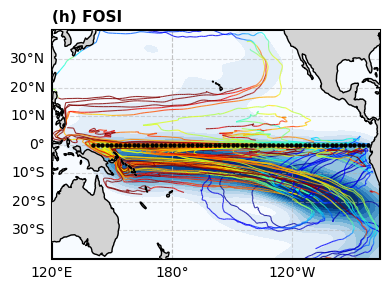

In [28]:
da = da_f
lon_data= lon_trunc_f[:, 0:244]
lat_data= lat_trunc_f[:, 0:244]
z_data= z_trunc_f[:, 0:244]
region_idx = region_idx_f

fig, ax = plt.subplots(figsize=(4, 3), #4, 3
                      subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180, globe=None)})
####### STATICS
ax.add_feature(cfeature.LAND, color='lightgray', zorder=100)
ax.add_feature(cfeature.COASTLINE, linewidth=1., zorder=100)
ax.grid(c='k', linestyle='dashed', alpha=0.2, zorder=4)
ax.set_extent([120, 284, -40, 40], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels={'left': True, 'bottom': True, 'right': False, 'top': False}, 
                  zorder=4, linestyle='--', alpha=0.5)
gl.xlabel_style = {'size': 10, 'color':'k'}  # Longitude labels
gl.ylabel_style = {'size': 10, 'color':'k'}  # Latitude labels
ax.spines['geo'].set_edgecolor('black')
ax.spines['geo'].set_linewidth(1.5)
ax.set_aspect('auto')

ax.scatter(lon_trunc_f[region_idx, 0][::2], lat_trunc_f[region_idx, 0][::2], 
           s=5, c='k', marker='o', edgecolor='k', zorder=200,transform=ccrs.PlateCarree())

# #### CONTOURF AND CONTOUR
contourf_plot = da_f.plot.contourf(
    x='lon', y='lat', cmap='Blues', add_colorbar=False, transform=ccrs.PlateCarree(),
    levels=11, vmax=30e-5, vmin=0, alpha=1)

#### TRAJECTORIES
for i in region_idx[::4]:
    lon = lon_data.isel(trajectory=i).values
    lat = lat_data.isel(trajectory=i).values
    depth = z_data.isel(trajectory=i).values
    points = np.array([lon, lat]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = mcollections.LineCollection(
            segments, cmap='jet', norm=plt.Normalize(0, 25000), 
            linewidth=0.8, alpha=0.8, transform=ccrs.PlateCarree())
    lc.set_array(depth[:-1])
    ax.add_collection(lc)

# #### COLORBAR
# density_sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(0e-5, 40e-5))
# density_sm.set_array([])
# density_cbar = plt.colorbar(density_sm, ax=ax, aspect=30, shrink=0.8, pad=0.1, orientation='horizontal')
# density_cbar.set_label('Normalized Trajectory Density', fontsize=11)
# tick_values = np.arange(0, 45, 5)  # This gives 5, 10, 15, 20, 25, 30
# density_cbar.set_ticks(tick_values * 1e-5)
# density_cbar.set_ticklabels([f'{x}' for x in tick_values])  # Shows as 5, 10, 15, etc.
# density_cbar.ax.tick_params(labelsize=12)

plt.title('(h) FOSI', fontsize=11, fontweight='bold', zorder=11, loc='left')
plt.tight_layout()
plt.show()

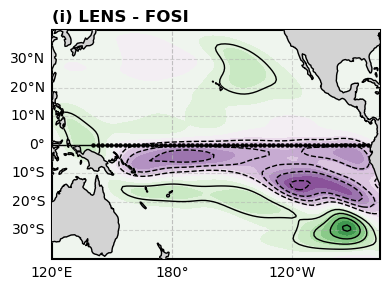

In [27]:
da_diff = da_l - da_f

fig, ax = plt.subplots(figsize=(4, 3),
                      subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180, globe=None)})
####### STATICS
ax.add_feature(cfeature.LAND, color='lightgray', zorder=100)
ax.add_feature(cfeature.COASTLINE, linewidth=1., zorder=100)
ax.grid(c='k', linestyle='dashed', alpha=0.2, zorder=4)
ax.set_extent([120, 284, -40, 40], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels={'left': True, 'bottom': True, 'right': False, 'top': False}, 
                  zorder=4, linestyle='--', alpha=0.5)
gl.xlabel_style = {'size': 10, 'color':'k'}  # Longitude labels
gl.ylabel_style = {'size': 10, 'color':'k'}  # Latitude labels
ax.spines['geo'].set_edgecolor('black')
ax.spines['geo'].set_linewidth(1.5)
ax.set_aspect('auto')
ax.axhline(y=0, color='k', linestyle='-', linewidth=1, zorder=5)

ax.scatter(lon_trunc_f[region_idx, 0][::2], lat_trunc_f[region_idx, 0][::2], 
           s=5, c='k', marker='o', edgecolor='k', zorder=200,transform=ccrs.PlateCarree())

# #### CONTOURF AND CONTOUR
contourf_plot = da_diff.plot.contourf(
    x='lon', y='lat', cmap='PRGn', add_colorbar=False, transform=ccrs.PlateCarree(),
    alpha=1, vmin=-30e-5, vmax=30e-5, levels=21)

da_diff.plot.contour(
    x='lon', y='lat', transform=ccrs.PlateCarree(), colors='k', linewidths=1,
    levels=[-20e-5, -15e-5, -10e-5, -5e-5, 5e-5, 10e-5, 15e-5, 20e-5], alpha=1)

# #### COLORBAR
# density_sm = plt.cm.ScalarMappable(cmap='PRGn', norm=plt.Normalize(-30e-5, 30e-5))
# density_sm.set_array([])
# density_cbar = plt.colorbar(density_sm, ax=ax, aspect=30, shrink=0.8, pad=0.1, orientation='horizontal')
# density_cbar.set_label('Normalized Trajectory Density', fontsize=11)
# tick_values = np.arange(-30, 35, 10)  # This gives 5, 10, 15, 20, 25, 30
# density_cbar.set_ticks(tick_values * 1e-5)
# density_cbar.set_ticklabels([f'{x}' for x in tick_values])  # Shows as 5, 10, 15, etc.
# density_cbar.ax.tick_params(labelsize=12)

plt.title('(i) LENS - FOSI', fontsize=12, fontweight='bold', zorder=11, loc='left')
plt.tight_layout()
plt.show()

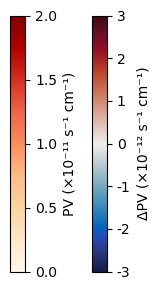

In [37]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(1.7, 3))

# Blues colorbar
density_sm1 = plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(0, 2e-11))
cbar1 = plt.colorbar(density_sm1, cax=ax1, orientation='vertical')
cbar1.set_label('PV (×10⁻¹¹ s⁻¹ cm⁻¹)', fontsize=10)
tick_values1 = np.arange(0, 2.1, 0.5)  # 0, 0.5, 1.0, 1.5, 2.0
cbar1.set_ticks(tick_values1 * 1e-11)
cbar1.set_ticklabels([f'{x:.1f}' for x in tick_values1])
cbar1.ax.tick_params(labelsize=10)

# Balance colorbar  
density_sm2 = plt.cm.ScalarMappable(cmap='PRGn', norm=plt.Normalize(-30e-5, 30e-5))
cbar2 = plt.colorbar(density_sm2, cax=ax2, orientation='vertical')
cbar2.set_label('ΔPV (×10⁻¹² s⁻¹ cm⁻¹)', fontsize=10)
tick_values2 = np.arange(-3, 3.1, 1)  # -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3
cbar2.set_ticks(tick_values2 * 1e-12)
cbar2.set_ticklabels([f'{x:.0f}' for x in tick_values2])
cbar2.ax.tick_params(labelsize=10)

density_sm2 = plt.cm.ScalarMappable(cmap='PRGn', norm=plt.Normalize(-30e-5, 30e-5))
cbar2 = plt.colorbar(density_sm2, cax=ax2, orientation='vertical')
cbar2.set_label('ΔPV (×10⁻¹² s⁻¹ cm⁻¹)', fontsize=10)
tick_values2 = np.arange(-3, 3.1, 1)  # -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3
cbar2.set_ticks(tick_values2 * 1e-12)
cbar2.set_ticklabels([f'{x:.0f}' for x in tick_values2])
cbar2.ax.tick_params(labelsize=10)

plt.tight_layout()
plt.show()

#### (a) and (b)

In [5]:
firstyear = 1959
lastyear = 2020 #2020
grid = pop_tools.get_grid('POP_gx1v7')
mask = xr.where((grid['REGION_MASK']>0) & (grid['REGION_MASK']<9), 1, np.nan)
fpath = '/glade/campaign/cesm/development/espwg/SMYLE/initial_conditions/SMYLE-FOSI/ocn/proc/tseries/month_1/'
fosi_montime_vals = [cftime.DatetimeNoLeap(1958+year, 1+month, 15) for year in range(63) for month in range(12)][0:240]

field = 'PD'
fname = f'g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.SMYLE.005.pop.h.{field}.030601-036812.nc'
ds_smyle_fosi_pd = xr.open_dataset(fpath+fname)[field].isel(z_t = 0, time=slice(0, 240)).compute()
ds_smyle_fosi_pd['time'] = fosi_montime_vals

FOSI_PD_1deg = proc_utils.regrid_SMYLE(ds_smyle_fosi_pd)#.mean(dim='time'))
FOSI_PD_DJF = FOSI_PD_1deg.where(FOSI_PD_1deg.time.dt.month.isin([6, 7, 8]), drop=True).mean(dim='time')

regridder = xe.Regridder(FOSI_PD_1deg, CESMLENS_var[:,:,:], 'nearest_s2d', periodic=True)

regridded_FOSI_PD_surf = regridder(FOSI_PD_DJF)

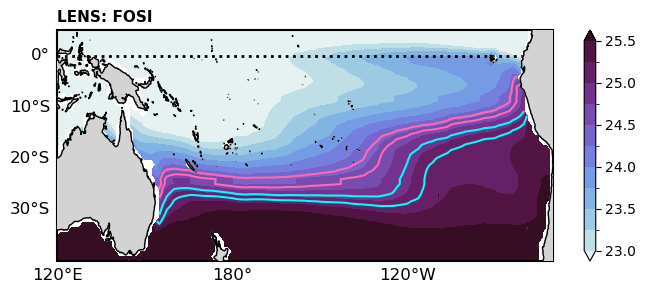

In [20]:
# LENS --------- Mean PD on 20°C Isotherm
fig, ax = plt.subplots(figsize=(8, 3), 
                      subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180, globe=None)})
####### STATICS
ax.add_feature(cfeature.LAND, color='lightgray', zorder=100)
ax.add_feature(cfeature.COASTLINE, linewidth=1., zorder=100)
ax.grid(c='k', linestyle='dashed', alpha=0.2, zorder=4)
ax.set_extent([120, 290, -40, 5], crs=ccrs.PlateCarree())
ax.set_aspect('auto')  # Override the equal aspect ratio

gl = ax.gridlines(draw_labels={'left': True, 'bottom': True, 'right': False, 'top': False}, 
                  zorder=4, linestyle='--', alpha=0.0)
gl.xlabel_style = {'size': 12}  # Longitude labels
gl.ylabel_style = {'size': 12}  # Latitude labels
ax.axhline(y=0, color='k', linestyle='dotted', linewidth=2, zorder=5)
ax.spines['geo'].set_edgecolor('black')
ax.spines['geo'].set_linewidth(1.5)

(regridded_FOSI_PD_surf*1000-1000).sel(lat=slice(-41, 6), lon=slice(120,290)).plot.contourf(
    vmin=23, vmax=25.5, levels=11, cmap=cmocean.cm.dense, transform=ccrs.PlateCarree(), add_colorbar=True)

(regridded_FOSI_PD_surf*1000-1000).plot.contour(levels=[24.4, 24.6], cmap='hotpink', transform=ccrs.PlateCarree())

(regridded_FOSI_PD_surf*1000-1000).plot.contour(levels=[24.9, 25.1], cmap='cyan', transform=ccrs.PlateCarree())


plt.title('')
plt.title('LENS: FOSI', fontsize=11, fontweight='bold', zorder=12, loc='left')
plt.show()

In [129]:
INIT_DEPTH = 50

file_path = '/glade/derecho/scratch/cassiacai/particle_trajectories/particle_trajectories_fosi_SH_startingat{}m_1958_1977.zarr'.format(
    INIT_DEPTH)

fosi_pt = xr.open_zarr(file_path)
f_time, f_lon, f_lat, f_z = stcfuncs.compute_data(fosi_pt)

In [7]:
def truncate_after_exit_equator(lon_data, lat_data, z_data):
    lon_data_truncated = lon_data.copy()
    lat_data_truncated = lat_data.copy()
    z_data_truncated = z_data.copy()
    
    # Define equatorial region boundaries
    lat_min, lat_max = -0.5, 0.5     # 2°S to 2°N
    lon_min, lon_max = 140, 305   # 200° to 280° longitude
    
    for i in range(lon_data.sizes['trajectory']):
        lon_traj = lon_data.isel(trajectory=i).values
        lat_traj = lat_data.isel(trajectory=i).values
        
        # Find where trajectory is within equatorial region (both lat and lon constraints)
        in_equator = ((lat_traj >= lat_min) & (lat_traj <= lat_max) & 
                      (lon_traj >= lon_min) & (lon_traj <= lon_max))
        
        # Find the last time the trajectory is in the equatorial region
        equator_indices = np.where(in_equator)[0]
        
        if len(equator_indices) > 0:
            last_in_equator = equator_indices[-1]
            
            # Find the first point AFTER last_in_equator that exits the equatorial region
            exit_found = False
            for j in range(last_in_equator + 1, len(lat_traj)):
                # Check if point is outside equatorial region (either lat or lon constraint violated)
                if (lat_traj[j] < lat_min or lat_traj[j] > lat_max or 
                    lon_traj[j] < lon_min or lon_traj[j] > lon_max):
                    # Truncate from this exit point onward
                    lon_data_truncated[i, j:] = np.nan
                    lat_data_truncated[i, j:] = np.nan
                    z_data_truncated[i, j:] = np.nan
                    exit_found = True
                    break
            
            # If trajectory ends while still in equatorial region, no truncation needed
            # (no action needed in this case)

    return lon_data_truncated, lat_data_truncated, z_data_truncated

In [131]:
lon_data=f_lon
lat_data=f_lat
z_data=f_z

lon_data_new, lat_data_new, z_data_new= truncate_after_exit_equator(
    lon_data, lat_data, z_data)

In [132]:
sigma_theta_pd = regridded_FOSI_PD_surf*1000-1000
yellow_indices = stcfuncs.find_sigma_theta_points(
    lon_data_new, lat_data_new, sigma_theta_pd, 
    sigma_min=24.9, sigma_max=25.1)

In [133]:
region_idx = yellow_indices

lat_min = -50
lat_max = 50

f_xi, f_yi, f_zi = stcfuncs.calc_density_sh(lon_data_new[yellow_indices,:].data.flatten(), lat_data_new[yellow_indices,:].data.flatten(),gridsize=100, 
                bw_method=None, lon_bounds=(110, 305), lat_bounds=(-50, 50))

da = xr.DataArray(f_zi, dims=['y', 'x'],
        coords={'lon': (['y', 'x'], f_xi), 'lat': (['y', 'x'], f_yi)}, name='density')
da_selected = da.where((da.lat >= lat_min) & (da.lat <= lat_max), drop=True)

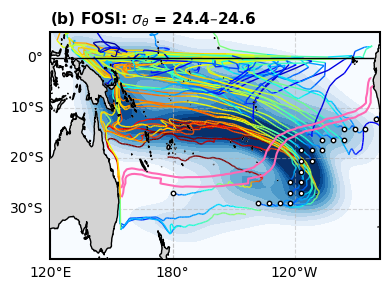

In [134]:
fig, ax = plt.subplots(figsize=(4, 3),
                      subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180, globe=None)})
####### STATICS
ax.add_feature(cfeature.LAND, color='lightgray', zorder=100)
ax.add_feature(cfeature.COASTLINE, linewidth=1., zorder=100)
ax.grid(c='k', linestyle='dashed', alpha=0.2, zorder=4)
ax.set_extent([120, 282, -40, 5], crs=ccrs.PlateCarree())

gl = ax.gridlines(draw_labels={'left': True, 'bottom': True, 'right': False, 'top': False}, 
                  zorder=4, linestyle='--', alpha=0.5)
gl.xlabel_style = {'size': 10}  # Longitude labels
gl.ylabel_style = {'size': 10}  # Latitude labels
ax.axhline(y=0, color='k', linestyle='-', linewidth=1, zorder=5)
ax.spines['geo'].set_edgecolor('black')
ax.spines['geo'].set_linewidth(1.5)
ax.set_aspect('auto')  

ax.scatter(f_lon[yellow_indices, 0], f_lat[yellow_indices, 0], 
           s=10, c='white', marker='o', edgecolor='k', zorder=100,transform=ccrs.PlateCarree())

####### DENSITY CONTOUR
contourf_plot = da_selected.plot.contourf(
    x='lon', y='lat', cmap='Blues', add_colorbar=False, transform=ccrs.PlateCarree(),
    levels=11, vmax=40e-5, vmin=0, alpha=1
)

for i in yellow_indices[::1]:
    lon = lon_data_new.isel(trajectory=i).values
    lat = lat_data_new.isel(trajectory=i).values
    depth = z_data_new.isel(trajectory=i).values
    points = np.array([lon, lat]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = mcollections.LineCollection(
            segments, cmap='jet', norm=plt.Normalize(0, 25000), 
            linewidth=1., alpha=1, transform=ccrs.PlateCarree())
    lc.set_array(depth[:-1])
    ax.add_collection(lc)
    
(regridded_FOSI_PD_surf*1000-1000).plot.contour(levels=[24.4, 24.6], cmap='hotpink',transform=ccrs.PlateCarree())

plt.title('')
plt.title('(b) FOSI: $\sigma_{\\theta}$ = 24.4–24.6', fontsize=11, fontweight='bold', zorder=12, loc='left')
plt.tight_layout()

plt.show()

In [9]:
ENS_MEMBERS_LIST = [0, 65,  32, 85, 61, 90, 80, 68, 73, 49] 
INIT_DEPTH = 50

region_indx_list = []; da_list = []
lon_trunc_list = []; lat_trunc_list = []; z_trunc_list = []
regridded_LENS_PD_surf_ls = []
for ENS_MEMB in ENS_MEMBERS_LIST:
    file_path = '/glade/derecho/scratch/cassiacai/particle_trajectories/particle_trajectories_lens{}_SH_startingat{}m_1958_1977.zarr'.format(
        ENS_MEMB, INIT_DEPTH)

    lens_pt = xr.open_zarr(file_path)
    l_time, l_lon, l_lat, l_z = stcfuncs.compute_data(lens_pt)
    print(ENS_MEMB)


    LENS_PD = stcfuncs.ocn_var_ens(ENS_MEMB, 'PD').isel(time=slice(0,240), z_t =0).compute()

    LENS_PD_1deg = proc_utils.regrid_SMYLE(LENS_PD)
    LENS_PD_DJF = LENS_PD_1deg.where(LENS_PD_1deg.time.dt.month.isin([6, 7, 8]), drop=True).mean(dim='time')
        
    regridded_LENS_PD_surf = regridder(LENS_PD_DJF)
    regridded_LENS_PD_surf_ls.append(regridded_LENS_PD_surf)
    lon_data=l_lon
    lat_data=l_lat
    z_data=l_z
    
    lon_data, lat_data, z_data= truncate_after_exit_equator(
        lon_data, lat_data, z_data)
    lon_trunc_list.append(lon_data)
    lat_trunc_list.append(lat_data)
    z_trunc_list.append(z_data)
    sigma_theta_pd = regridded_LENS_PD_surf*1000-1000
    yellow_indices = stcfuncs.find_sigma_theta_points(lon_data, lat_data, sigma_theta_pd, sigma_min=24.9, sigma_max=25.1)

    lat_min = -50
    lat_max = 50
    
    f_xi, f_yi, f_zi = stcfuncs.calc_density_sh(lon_data[yellow_indices,:].data.flatten(), lat_data[yellow_indices,:].data.flatten(),gridsize=100, 
                    bw_method=None, lon_bounds=(110, 305), lat_bounds=(-50, 50))
    
    da = xr.DataArray(f_zi, dims=['y', 'x'],
            coords={'lon': (['y', 'x'], f_xi), 'lat': (['y', 'x'], f_yi)}, name='density')
        
    da_selected = da.where((da.lat >= lat_min) & (da.lat <= lat_max), drop=True)

    region_indx_list.append(yellow_indices)
    da_list.append(da_selected)

0
65
32
85
61
90
80
68
73
49


In [10]:
da_xr = xr.concat(da_list, dim='ensemble').mean(dim='ensemble')

In [11]:
PD_xr = xr.concat(regridded_LENS_PD_surf_ls, dim='ensemble').mean(dim='ensemble')

In [138]:
yellow_indices_new = stcfuncs.find_sigma_theta_points(lon_data, lat_data, PD_xr*1000-1000, sigma_min=24.9, sigma_max=25.1)

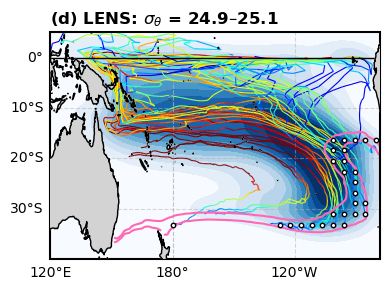

In [144]:
fig, ax = plt.subplots(figsize=(4, 3),
                      subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180, globe=None)})
####### STATICS
ax.add_feature(cfeature.LAND, color='lightgray', zorder=100)
ax.add_feature(cfeature.COASTLINE, linewidth=1., zorder=100)
ax.grid(c='k', linestyle='dashed', alpha=0.2, zorder=4)
ax.set_extent([120, 282, -40, 5], crs=ccrs.PlateCarree())
# ax.set_extent([120, 140, -5, 15], crs=ccrs.PlateCarree())

gl = ax.gridlines(draw_labels={'left': True, 'bottom': True, 'right': False, 'top': False}, 
                  zorder=4, linestyle='--', alpha=0.5)
gl.xlabel_style = {'size': 10}  # Longitude labels
gl.ylabel_style = {'size': 10}  # Latitude labels
ax.axhline(y=0, color='k', linestyle='-', linewidth=1, zorder=5)
ax.spines['geo'].set_edgecolor('black')
ax.spines['geo'].set_linewidth(1.5)
ax.set_aspect('auto')  # Override the equal aspect ratio
ax.scatter(lon_data[yellow_indices_new, 0], lat_data[yellow_indices_new, 0], 
           s=10, c='white', marker='o', edgecolor='k', zorder=100,transform=ccrs.PlateCarree())

contourf_plot = da_xr.plot.contourf(
    x='lon', y='lat', cmap='Blues', add_colorbar=False, transform=ccrs.PlateCarree(),
    levels=11, vmax=40e-5, vmin=0, alpha=1
)

for i in region_indx_list[8][::1]:
    lon = lon_trunc_list[8].isel(trajectory=i).values
    lat = lat_trunc_list[8].isel(trajectory=i).values
    depth = z_trunc_list[8].isel(trajectory=i).values
    points = np.array([lon, lat]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = mcollections.LineCollection(
            segments, cmap='jet', norm=plt.Normalize(0, 25000), 
            linewidth=0.8, alpha=1, transform=ccrs.PlateCarree())
    lc.set_array(depth[:-1])
    ax.add_collection(lc)
    
(PD_xr*1000-1000).plot.contour(levels=[24.9, 25.1], cmap='hotpink',transform=ccrs.PlateCarree())

# TITLE
plt.title('')
plt.title('(d) LENS: $\sigma_{\\theta}$ = 24.9–25.1', fontsize=12, fontweight='bold', zorder=12, loc='left')
plt.tight_layout()
plt.show()

In [145]:
diff_xr = xr.concat(da_list, dim='ensemble') - da_selected
diff_xr.mean(dim=('y','x')).argmin()

<xarray.DataArray 'density' ()> Size: 8B
array(8)

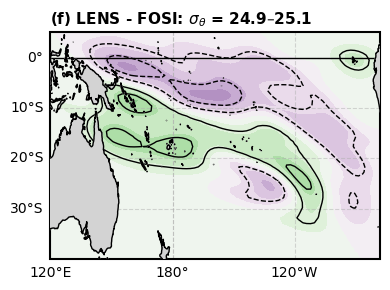

In [147]:
diff = da_xr - da_selected
fig, ax = plt.subplots(figsize=(4, 3),
                      subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180, globe=None)})
####### STATICS
ax.add_feature(cfeature.LAND, color='lightgray', zorder=100)
ax.add_feature(cfeature.COASTLINE, linewidth=1., zorder=100)
ax.grid(c='k', linestyle='dashed', alpha=0.2, zorder=4)
ax.set_extent([120, 282, -40, 5], crs=ccrs.PlateCarree())
# ax.set_extent([120, 140, -5, 15], crs=ccrs.PlateCarree())

gl = ax.gridlines(draw_labels={'left': True, 'bottom': True, 'right': False, 'top': False}, 
                  zorder=4, linestyle='--', alpha=0.5)
gl.xlabel_style = {'size': 10}  # Longitude labels
gl.ylabel_style = {'size': 10}  # Latitude labels
ax.axhline(y=0, color='k', linestyle='-', linewidth=1, zorder=5)
ax.spines['geo'].set_edgecolor('black')
ax.spines['geo'].set_linewidth(1.5)
ax.set_aspect('auto')  # Override the equal aspect ratio


####### DENSITY CONTOUR
contourf_plot = diff.plot.contourf(
    x='lon', y='lat', cmap='PRGn', add_colorbar=False, transform=ccrs.PlateCarree(),
    levels=21, 
    vmax=30e-5, 
    vmin=-30e-5, alpha=1
)

diff.plot.contour(
    x='lon', y='lat', transform=ccrs.PlateCarree(), colors='k', linewidths=1,
    levels=[-20e-5, -15e-5, -10e-5, -5e-5, 5e-5, 10e-5, 15e-5, 20e-5], alpha=1)

# TITLE
plt.title('')
plt.title('(f) LENS - FOSI: $\sigma_{\\theta}$ = 24.9–25.1', fontsize=11, fontweight='bold', zorder=12, loc='left')
plt.tight_layout()
plt.show()

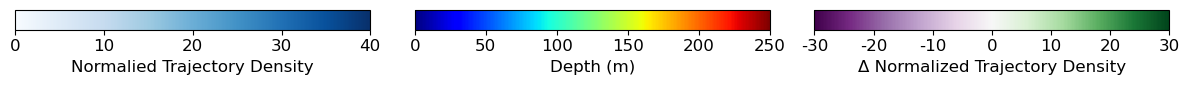

In [149]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 0.95))

# Blues colorbar
density_sm1 = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(0, 40e-5))
cbar1 = plt.colorbar(density_sm1, cax=ax1, orientation='horizontal')
cbar1.set_label('Normalied Trajectory Density', fontsize=12)
tick_values1 = np.arange(0, 45, 10)  # 0, 0.5, 1.0, 1.5, 2.0
cbar1.set_ticks(tick_values1 * 1e-5)
cbar1.set_ticklabels([f'{x:.0f}' for x in tick_values1])
cbar1.ax.tick_params(labelsize=12)

# Balance colorbar  
density_sm2 = plt.cm.ScalarMappable(cmap='jet', norm=plt.Normalize(0, 250))
cbar2 = plt.colorbar(density_sm2, cax=ax2, orientation='horizontal')
cbar2.set_label('Depth (m)', fontsize=12)
tick_values2 = np.arange(0, 260, 50)  # -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3
cbar2.set_ticks(tick_values2 * 1)
cbar2.set_ticklabels([f'{x:.0f}' for x in tick_values2])
cbar2.ax.tick_params(labelsize=12)

# Balance colorbar  
density_sm2 = plt.cm.ScalarMappable(cmap='PRGn', norm=plt.Normalize(-30e-5, 30e-5))
cbar2 = plt.colorbar(density_sm2, cax=ax3, orientation='horizontal')
cbar2.set_label('Δ Normalized Trajectory Density', fontsize=12)
tick_values2 = np.arange(-30, 35, 10)  # -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3
cbar2.set_ticks(tick_values2 * 1e-5)
cbar2.set_ticklabels([f'{x:.0f}' for x in tick_values2])
cbar2.ax.tick_params(labelsize=12)

plt.tight_layout()
plt.show()

### Supplementary Figure 6

In [12]:
# LENS for regridding purposes
CESMLENS_var = afuncs.LENS_for_regridding() # this is Area

#### FOSI set up
firstyear = 1959
lastyear = 2020
grid = pop_tools.get_grid('POP_gx1v7')
mask = xr.where((grid['REGION_MASK']>0) & (grid['REGION_MASK']<9), 1, np.nan)
fpath = '/glade/campaign/cesm/development/espwg/SMYLE/initial_conditions/SMYLE-FOSI/ocn/proc/tseries/month_1/'
fosi_montime_vals = [cftime.DatetimeNoLeap(1958+year, 1+month, 15) for year in range(63) for month in range(12)]

In [86]:
field = 'TEMP'
fname = f'g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.SMYLE.005.pop.h.{field}.030601-036812.nc'
fpath = '/glade/campaign/cesm/development/espwg/SMYLE/initial_conditions/SMYLE-FOSI/ocn/proc/tseries/month_1/'
ds_smyle_fosi_var = xr.open_dataset(fpath+fname)[field]
ds_smyle_fosi_var['time'] = fosi_montime_vals
var_fosi = ds_smyle_fosi_var.isel(z_t = 0).compute()
fosi_1deg_wzeros_var = regrid_SMYLE(var_fosi)
fosi_1deg_var = fosi_1deg_wzeros_var.where(fosi_1deg_wzeros_var!=0, np.nan).isel(time=slice(0, 685))

In [90]:
regridder = xe.Regridder(fosi_1deg_var, CESMLENS_var[:,:,:], 'nearest_s2d', periodic=True)
regridded_fosi_SST = regridder(fosi_1deg_var)

In [91]:
def detrend_gridpoint(da, time_coord='time'):
    time_decimal = da[time_coord].dt.year + da[time_coord].dt.month / 12
    
    def _linregress(y):
        mask = ~np.isnan(y)
        if np.sum(mask) > 1:
            slope, intercept = np.polyfit(time_decimal[mask], y[mask], 1)
            return intercept + slope * time_decimal
        else:
            return np.full_like(y, np.nan)
    
    # Apply to all grid points
    detrended = xr.apply_ufunc(
        _linregress,
        da,
        input_core_dims=[[time_coord]],
        output_core_dims=[[time_coord]],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[float]
    )
    return da - detrended

In [92]:
detrended_SST = detrend_gridpoint(regridded_fosi_SST)

In [94]:
regridded_FOSI_PD_surf_use = regridded_FOSI_PD_surf*1000 - 1000
mask = xr.where(
    (regridded_FOSI_PD_surf_use >= 24.4) & (regridded_FOSI_PD_surf_use <= 24.6),
    1,  # Values in range
    np.nan   # Values outside range
)

mask = (regridded_FOSI_PD_surf_use >= 24.4) & (regridded_FOSI_PD_surf_use <= 24.6)
mask = mask.astype(int)  # Convert boolean to 0/1

In [114]:
SST_in_outcrop_region = detrended_SST*mask

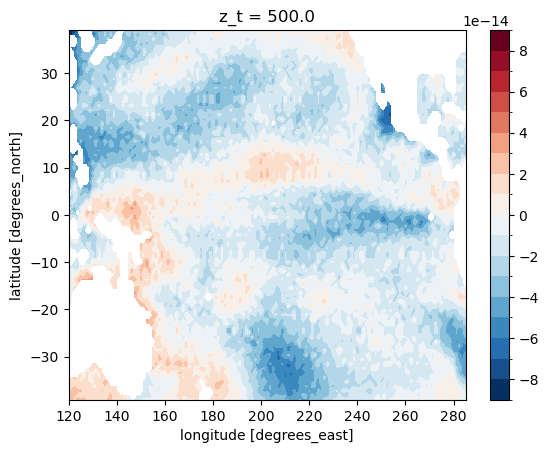

In [128]:
detrended_SST.mean(dim='time').sel(lat=slice(-40,40), lon=slice(120, 285)).plot.contourf(levels=20)

In [115]:
SST_in_outcrop_region_nan = xr.where(SST_in_outcrop_region == 0., np.nan, SST_in_outcrop_region)

In [116]:
SST_in_outcrop_region_nan = detrended_SST.sel(lat=slice(-40, -30), lon=slice(260, 280)).mean(dim=('lat','lon'))

In [171]:
# If outcrop leads by 10 years:
# Outcrop at time t predicts SST at time t+10
# So we compare: outcrop(t) with SST(t+10)

lead_years = 10
lead_months = lead_years * 12

# outcrop_lead = SST_in_outcrop_region_nan.sel(
#     lat=slice(-40, 5), 
#     lon=slice(120, 284)
# ).mean(dim=('lat','lon')).isel(time=slice(0, -lead_months))

outcrop_lead = detrended_SST.sel(lat=slice(-40, -25), lon=slice(250, 285)).mean(dim=('lat','lon')).isel(time=slice(0, -lead_months))

# SST field (starting 10 years later, going to end)
sst_lag = detrended_SST.isel(time=slice(lead_months, None))

# Apply 10-year rolling mean
outcrop_smoothed = outcrop_lead.rolling(time=12*10, center=True).mean()
sst_smoothed = sst_lag.rolling(time=12*10, center=True).mean()

# Calculate correlation
corr_xr_10yr_lead = xr.corr(outcrop_smoothed, sst_smoothed, dim='time')

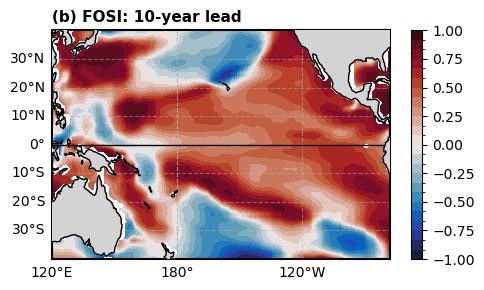

In [156]:
fig, ax = plt.subplots(figsize=(5, 3),
                      subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180, globe=None)})
####### STATICS
ax.add_feature(cfeature.LAND, color='lightgray', zorder=100)
ax.add_feature(cfeature.COASTLINE, linewidth=1., zorder=100)
ax.grid(c='k', linestyle='dashed', alpha=0.2, zorder=4)
ax.set_extent([120, 282, -40, 40], crs=ccrs.PlateCarree())

gl = ax.gridlines(draw_labels={'left': True, 'bottom': True, 'right': False, 'top': False}, 
                  zorder=4, linestyle='--', alpha=0.5)
gl.xlabel_style = {'size': 10}  # Longitude labels
gl.ylabel_style = {'size': 10}  # Latitude labels
ax.axhline(y=0, color='k', linestyle='-', linewidth=1, zorder=5)
ax.spines['geo'].set_edgecolor('black')
ax.spines['geo'].set_linewidth(1.5)
ax.set_aspect('auto')  # Override the equal aspect ratio


####### DENSITY CONTOUR
corr_10yr_lead.sel(lat=slice(-41, 41), lon=slice(120, 284)).plot.contourf(
    levels=25, vmin=-1, vmax=1, cmap=cmocean.cm.balance, transform=ccrs.PlateCarree())

plt.title('')
plt.title('(b) FOSI: 10-year lead', fontsize=11, fontweight='bold', zorder=12, loc='left')
plt.tight_layout()
plt.show()

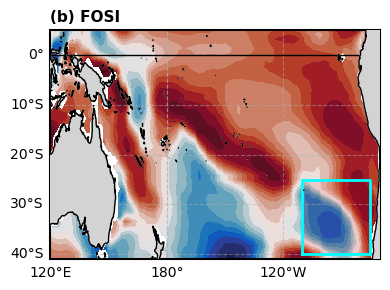

In [196]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import cmocean
import numpy as np

fig, ax = plt.subplots(figsize=(4, 3),
                      subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180, globe=None)})

####### STATICS
ax.add_feature(cfeature.LAND, color='lightgray', zorder=100)
ax.add_feature(cfeature.COASTLINE, linewidth=1., zorder=100)
ax.grid(c='k', linestyle='dashed', alpha=0.2, zorder=4)
ax.set_extent([120, 290, -41, 5], crs=ccrs.PlateCarree())

gl = ax.gridlines(draw_labels={'left': True, 'bottom': True, 'right': False, 'top': False}, 
                  zorder=4, linestyle='--', alpha=0.5)
gl.xlabel_style = {'size': 10}  # Longitude labels
gl.ylabel_style = {'size': 10}  # Latitude labels
ax.axhline(y=0, color='k', linestyle='-', linewidth=1, zorder=5)
ax.spines['geo'].set_edgecolor('black')
ax.spines['geo'].set_linewidth(1.5)
ax.set_aspect('auto')  # Override the equal aspect ratio

####### DENSITY CONTOUR
corr_10yr_lead.sel(lat=slice(-41, 41), lon=slice(120, 295)).plot.contourf(
    ax=ax, levels=21, vmin=-1, vmax=1, cmap=cmocean.cm.balance, 
    transform=ccrs.PlateCarree(), add_colorbar=False, zorder=1)

# ####### ADD COLORBAR
# cbar = plt.colorbar(ax.collections[0], ax=ax, orientation='horizontal', 
#                     pad=0.05, aspect=30, shrink=0.8)
# cbar.set_label('Correlation', fontsize=10)

####### ADD BOX FOR OUTCROP REGION
# Define box coordinates
box_lats = [-40, -25, -25, -40, -40]
box_lons = [250, 250, 285, 285, 250]

# Plot the box
ax.plot(box_lons, box_lats, 'cyan', linewidth=2, transform=ccrs.PlateCarree(), 
        zorder=10, label='Outcrop region')

# Optional: Fill the box with semi-transparent color
ax.fill(box_lons, box_lats, 'red', alpha=0.1, transform=ccrs.PlateCarree(), 
        zorder=9)
plt.title('')
####### TITLE AND FINAL TOUCHES
plt.title('(b) FOSI', fontsize=11, fontweight='bold', 
          zorder=12, loc='left')
plt.tight_layout()
plt.show()

In [308]:
ENS_MEMB = 0
LENS_SST = afuncs.atm_var_ens(ENS_MEMB, 'SST')

In [62]:
ENS_MEMBERS_LIST = [0, 65,  32, 85, 61, 90, 80, 68, 73, 49] 
LENS_SST_LIST =[]
for ENS_MEMB in ENS_MEMBERS_LIST:
    LENS_SST = afuncs.atm_var_ens(ENS_MEMB, 'SST')
    LENS_SST_LIST.append(LENS_SST)

In [64]:
LENS_SST_concat = xr.concat(LENS_SST_LIST, dim='ensemble')

In [65]:
detrended_LENS_SST = detrend_gridpoint(LENS_SST)

In [66]:
# Create binary mask: 1 where 24.4 <= value <= 24.6, 0 otherwise
regridded_LENS_PD_surf_use = PD_xr*1000 - 1000
mask_LENS = xr.where(
    (PD_xr >= 24.4) & (PD_xr <= 24.6),
    1,  # Values in range
    np.nan   # Values outside range
)

mask_LENS = (regridded_LENS_PD_surf_use >= 24.4) & (regridded_LENS_PD_surf_use <= 24.6)
mask_LENS = mask_LENS.astype(int)  # Convert boolean to 0/1

In [67]:
LENS_SST_in_outcrop_region = detrended_LENS_SST*mask_LENS

In [174]:
# Outcrop leads by 10 years (outcrop at time t is compared with SST at time t+10)
lead_years = 10
lead_months = lead_years * 12

# Shift the outcrop time series BACKWARD by 10 years
outcrop_shifted_LENS = detrended_LENS_SST.sel(lat=slice(-40, -25), lon=slice(250, 285)).mean(dim=('lat','lon')).isel(time=slice(0, -lead_months))

# Shift the SST field FORWARD by 10 years  
# sst_shifted_LENS = detrended_LENS_SST.isel(time=slice(0, -lead_months))
sst_shifted_LENS = detrended_LENS_SST.isel(time=slice(lead_months, None))

# Apply 10-year rolling mean to both (now they're aligned in time)
outcrop_10yr_mean_LENS = outcrop_shifted_LENS.rolling(time=12*10, center=True).mean()
sst_10yr_mean_LENS = sst_shifted_LENS.rolling(time=12*10, center=True).mean()

# Calculate correlation
corr_10yr_lead_LENS = xr.corr(outcrop_10yr_mean_LENS, sst_10yr_mean_LENS, dim='time')

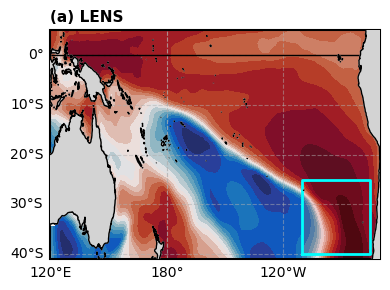

In [197]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import cmocean
import numpy as np

fig, ax = plt.subplots(figsize=(4, 3),
                      subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180, globe=None)})

####### STATICS
ax.add_feature(cfeature.LAND, color='lightgray', zorder=100)
ax.add_feature(cfeature.COASTLINE, linewidth=1., zorder=100)
ax.grid(c='k', linestyle='dashed', alpha=0.2, zorder=4)
ax.set_extent([120, 290, -41, 5], crs=ccrs.PlateCarree())

gl = ax.gridlines(draw_labels={'left': True, 'bottom': True, 'right': False, 'top': False}, 
                  zorder=4, linestyle='--', alpha=0.5)
gl.xlabel_style = {'size': 10}  # Longitude labels
gl.ylabel_style = {'size': 10}  # Latitude labels
ax.axhline(y=0, color='k', linestyle='-', linewidth=1, zorder=5)
ax.spines['geo'].set_edgecolor('black')
ax.spines['geo'].set_linewidth(1.5)
ax.set_aspect('auto')  # Override the equal aspect ratio

####### DENSITY CONTOUR
corr_10yr_lead_LENS.sel(lat=slice(-41, 41), lon=slice(120, 295)).plot.contourf(
    ax=ax, levels=21, vmin=-1, vmax=1, cmap=cmocean.cm.balance, 
    transform=ccrs.PlateCarree(), add_colorbar=False, zorder=1)

# ####### ADD COLORBAR
# cbar = plt.colorbar(ax.collections[0], ax=ax, orientation='horizontal', 
#                     pad=0.05, aspect=30, shrink=0.8)
# cbar.set_label('Correlation', fontsize=10)

####### ADD BOX FOR OUTCROP REGION
# Define box coordinates
box_lats = [-40, -25, -25, -40, -40]
box_lons = [250, 250, 285, 285, 250]

# Plot the box
ax.plot(box_lons, box_lats, 'cyan', linewidth=2, transform=ccrs.PlateCarree(), 
        zorder=10, label='Outcrop region')

# Optional: Fill the box with semi-transparent color
ax.fill(box_lons, box_lats, 'red', alpha=0.1, transform=ccrs.PlateCarree(), 
        zorder=9)
plt.title('')
####### TITLE AND FINAL TOUCHES
plt.title('(a) LENS', fontsize=11, fontweight='bold', 
          zorder=12, loc='left')
plt.tight_layout()
plt.show()

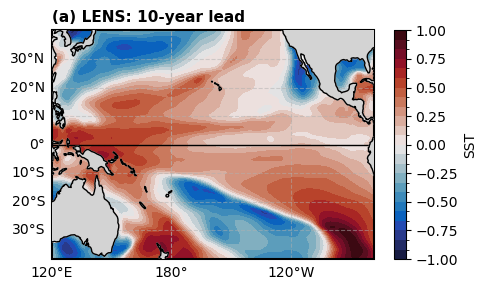

In [155]:
fig, ax = plt.subplots(figsize=(5, 3),
                      subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180, globe=None)})
####### STATICS
ax.add_feature(cfeature.LAND, color='lightgray', zorder=100)
ax.add_feature(cfeature.COASTLINE, linewidth=1., zorder=100)
ax.grid(c='k', linestyle='dashed', alpha=0.2, zorder=4)
ax.set_extent([120, 282, -40, 40], crs=ccrs.PlateCarree())

gl = ax.gridlines(draw_labels={'left': True, 'bottom': True, 'right': False, 'top': False}, 
                  zorder=4, linestyle='--', alpha=0.5)
gl.xlabel_style = {'size': 10}  # Longitude labels
gl.ylabel_style = {'size': 10}  # Latitude labels
ax.axhline(y=0, color='k', linestyle='-', linewidth=1, zorder=5)
ax.spines['geo'].set_edgecolor('black')
ax.spines['geo'].set_linewidth(1.5)
ax.set_aspect('auto')  # Override the equal aspect ratio


####### DENSITY CONTOUR
corr_10yr_lead_LENS.sel(lat=slice(-41, 41), lon=slice(120, 284)).plot.contourf(
    levels=25, vmin=-1, vmax=1, cmap=cmocean.cm.balance, transform=ccrs.PlateCarree())

plt.title('')
plt.title('(a) LENS: 10-year lead', 
          fontsize=11, fontweight='bold', zorder=12, loc='left')
plt.tight_layout()
plt.show()

In [152]:
diff_corr = np.abs(corr_10yr_lead_LENS) - np.abs(corr_10yr_lead)

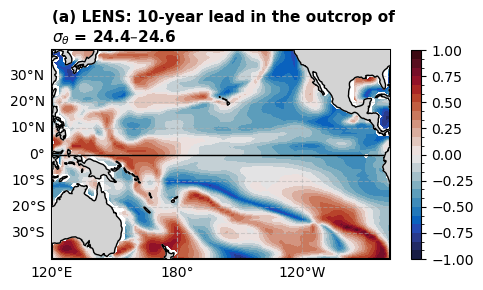

In [154]:
fig, ax = plt.subplots(figsize=(5, 3),
                      subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180, globe=None)})
####### STATICS
ax.add_feature(cfeature.LAND, color='lightgray', zorder=100)
ax.add_feature(cfeature.COASTLINE, linewidth=1., zorder=100)
ax.grid(c='k', linestyle='dashed', alpha=0.2, zorder=4)
ax.set_extent([120, 282, -40, 40], crs=ccrs.PlateCarree())

gl = ax.gridlines(draw_labels={'left': True, 'bottom': True, 'right': False, 'top': False}, 
                  zorder=4, linestyle='--', alpha=0.5)
gl.xlabel_style = {'size': 10}  # Longitude labels
gl.ylabel_style = {'size': 10}  # Latitude labels
ax.axhline(y=0, color='k', linestyle='-', linewidth=1, zorder=5)
ax.spines['geo'].set_edgecolor('black')
ax.spines['geo'].set_linewidth(1.5)
ax.set_aspect('auto')  # Override the equal aspect ratio


####### DENSITY CONTOUR
diff_corr.sel(lat=slice(-41, 41), lon=slice(120, 284)).plot.contourf(
    levels=25, vmin=-1, vmax=1, cmap=cmocean.cm.balance, transform=ccrs.PlateCarree())

plt.title('')
plt.title('(a) LENS: 10-year lead in the outcrop of \n$\sigma_{\\theta}$ = 24.4–24.6', 
          fontsize=11, fontweight='bold', zorder=12, loc='left')
plt.tight_layout()
plt.show()

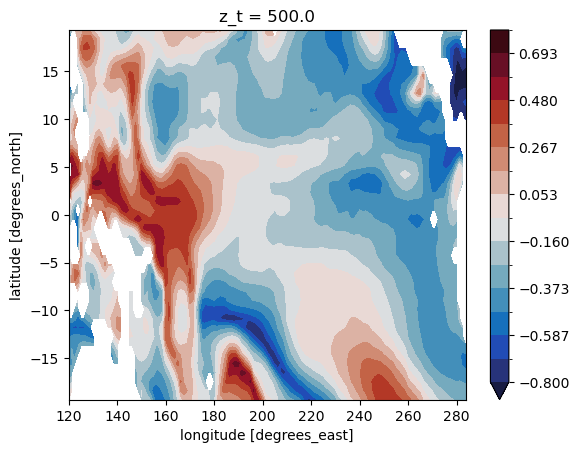

In [153]:
diff_corr.sel(lat=slice(-20, 20), lon=slice(120, 284)).plot.contourf(
    levels=16, vmin=-0.8, vmax=0.8, cmap=cmocean.cm.balance)

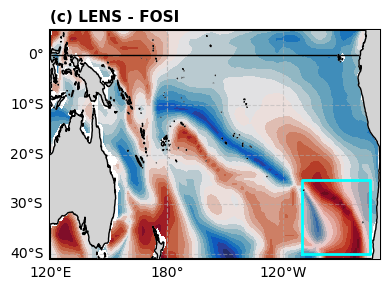

In [193]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import cmocean
import numpy as np

fig, ax = plt.subplots(figsize=(4, 3),
                      subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180, globe=None)})

####### STATICS
ax.add_feature(cfeature.LAND, color='lightgray', zorder=100)
ax.add_feature(cfeature.COASTLINE, linewidth=1., zorder=100)
ax.grid(c='k', linestyle='dashed', alpha=0.2, zorder=4)
ax.set_extent([120, 290, -41, 5], crs=ccrs.PlateCarree())

gl = ax.gridlines(draw_labels={'left': True, 'bottom': True, 'right': False, 'top': False}, 
                  zorder=4, linestyle='--', alpha=0.5)
gl.xlabel_style = {'size': 10}  # Longitude labels
gl.ylabel_style = {'size': 10}  # Latitude labels
ax.axhline(y=0, color='k', linestyle='-', linewidth=1, zorder=5)
ax.spines['geo'].set_edgecolor('black')
ax.spines['geo'].set_linewidth(1.5)
ax.set_aspect('auto')  # Override the equal aspect ratio

####### DENSITY CONTOUR
diff_corr.sel(lat=slice(-41, 41), lon=slice(120, 295)).plot.contourf(
    ax=ax, levels=21, vmin=-1, vmax=1, cmap=cmocean.cm.balance, 
    transform=ccrs.PlateCarree(), add_colorbar=False, zorder=1)

# ####### ADD COLORBAR
# cbar = plt.colorbar(ax.collections[0], ax=ax, orientation='horizontal', 
#                     pad=0.05, aspect=30, shrink=0.8)
# cbar.set_label('Correlation', fontsize=10)

####### ADD BOX FOR OUTCROP REGION
# Define box coordinates
box_lats = [-40, -25, -25, -40, -40]
box_lons = [250, 250, 285, 285, 250]

# Plot the box
ax.plot(box_lons, box_lats, 'cyan', linewidth=2, transform=ccrs.PlateCarree(), 
        zorder=10, label='Outcrop region')

# Optional: Fill the box with semi-transparent color
ax.fill(box_lons, box_lats, 'red', alpha=0.1, transform=ccrs.PlateCarree(), 
        zorder=9)
plt.title('')
####### TITLE AND FINAL TOUCHES
plt.title('(c) LENS - FOSI', fontsize=11, fontweight='bold', 
          zorder=12, loc='left')
plt.tight_layout()
plt.show()

### Monthly sensitivity tests (not shown)

#### Functions

In [29]:
def truncate_after_first_exit_equator(lon_data, lat_data, z_data):
    lon_data_truncated = lon_data.copy()
    lat_data_truncated = lat_data.copy()
    z_data_truncated = z_data.copy()
    
    # Define equatorial region boundaries
    lat_min, lat_max = -1, 1     # 2°S to 2°N
    lon_min, lon_max = 140, 305   # 200° to 280° longitude
    
    for i in range(lon_data.sizes['trajectory']):
        lon_traj = lon_data.isel(trajectory=i).values
        lat_traj = lat_data.isel(trajectory=i).values
        
        # Track if we've entered the equatorial region at least once
        has_entered_equator = False
        first_exit_index = None
        
        for j in range(len(lat_traj)):
            # Check if current point is in equatorial region
            in_equator = ((lat_traj[j] >= lat_min) & (lat_traj[j] <= lat_max) & 
                          (lon_traj[j] >= lon_min) & (lon_traj[j] <= lon_max))
            
            if in_equator:
                has_entered_equator = True
            elif has_entered_equator and first_exit_index is None:
                # We've entered equator before and now we're exiting for the first time
                first_exit_index = j
                break
        # Truncate after first exit point
        if first_exit_index is not None:
            lon_data_truncated[i, first_exit_index:] = np.nan
            lat_data_truncated[i, first_exit_index:] = np.nan
            z_data_truncated[i, first_exit_index:] = np.nan
       #     print(f"Trajectory {i}: first exit at index {first_exit_index}")
       # elif has_entered_equator:
      #      print(f"Trajectory {i}: entered equator but never exited")
      #  else:
      #      print(f"Trajectory {i}: never entered equator")

    return lon_data_truncated, lat_data_truncated, z_data_truncated        

In [30]:
def get_region_lonlat(lat_data, lon_data, region_lat_min, region_lat_max, region_lon_min, region_lon_max):
    index_min = 0
    index_max = 400
    
    in_region_mask = (
        (lat_data[index_min:index_max, 0] >= region_lat_min) & 
        (lat_data[index_min:index_max, 0] <= region_lat_max) &
        (lon_data[index_min:index_max, 0] >= region_lon_min) & 
        (lon_data[index_min:index_max, 0] <= region_lon_max)
    )
    
    region_indices = np.where(in_region_mask)[0] + index_min
    return region_indices

In [31]:
def calc_density(lon_data, lat_data, z_data, lat_min, lat_max, lon_min, lon_max, timestart, timeend):
    
    lon_trunc,lat_trunc, z_trunc = truncate_after_first_exit_equator(#truncate_after_exit_equator(#truncate_lonlatz(
        lon_data, lat_data, z_data)

    region_idx = get_region_lonlat(lat_trunc, lon_trunc, lat_min, lat_max, lon_min, lon_max)
    # region_idx_p1 = get_region_lonlat(lat_trunc, lon_trunc, -35, -30, 220, 240)
    # region_idx_p2 = get_region_lonlat(lat_trunc, lon_trunc, -40, -35, 220,240)
    
    lons_points = lon_trunc[region_idx, timestart:timeend].data.flatten()
    lats_points = lat_trunc[region_idx, timestart:timeend].data.flatten()
    
    f_xi, f_yi, f_zi = calc_density_sh(lons_points, lats_points)
    
    da = xr.DataArray(f_zi, dims=['y', 'x'],
        coords={'lon': (['y', 'x'], f_xi),'lat': (['y', 'x'], f_yi)},name='density')
    
    # da_nan = xr.where(da <= 0.000001, np.nan, da)
    # return da_nan, region_idx, lon_trunc,lat_trunc, z_trunc
    return da, region_idx, lon_trunc,lat_trunc, z_trunc

In [35]:
def calc_density_sh(lons, lats, gridsize=100, bw_method=None, lon_bounds=(110, 305), lat_bounds=(-50, 50)):
    """
    Calculate 2D Gaussian KDE density with fixed grid bounds.
    """
    # Remove NaN values
    valid_mask = ~np.isnan(lons) & ~np.isnan(lats)
    lons_clean = lons[valid_mask]
    lats_clean = lats[valid_mask]
    
    if len(lons_clean) == 0:
        raise ValueError("No valid data points for KDE calculation")
    
    # Use fixed bounds instead of data-derived bounds
    xi = np.linspace(lon_bounds[0], lon_bounds[1], gridsize)
    yi = np.linspace(lat_bounds[0], lat_bounds[1], gridsize)
    f_xi, f_yi = np.meshgrid(xi, yi)
    
    # Calculate Gaussian KDE
    coordinates = np.vstack([lons_clean, lats_clean])
    kde = gaussian_kde(coordinates, bw_method=bw_method)
    
    # Evaluate KDE on the fixed grid
    grid_coords = np.vstack([f_xi.ravel(), f_yi.ravel()])
    f_zi = kde(grid_coords).reshape(f_xi.shape)
    
    return f_xi, f_yi, f_zi

#### Analysis

In [36]:
def truncate_lonlatz(lon_data, lat_data, z_data):
    lon_data_truncated = lon_data.copy()
    lat_data_truncated = lat_data.copy()
    z_data_truncated = z_data.copy()
    
    # lon_min, lon_max = 260, 291
    lon_min, lon_max = 260, 280#290, 291 #260, 280
    lat_min, lat_max = -1, 1
    
    for i in range(lon_data.sizes['trajectory']):
        lon_traj = lon_data.isel(trajectory=i).values
        lat_traj = lat_data.isel(trajectory=i).values
        
        in_target_region = (lon_traj >= lon_min) & (lon_traj <= lon_max) & (lat_traj >= lat_min) & (lat_traj <= lat_max)
        
        # Find first occurrence in target region
        region_indices = np.where(in_target_region)[0]
        
        if len(region_indices) > 0:
            first_in_region = region_indices[0]
            # Set all observations after entering region to NaN
            lon_data_truncated[i, first_in_region+1:] = np.nan
            lat_data_truncated[i, first_in_region+1:] = np.nan
            z_data_truncated[i, first_in_region+1:] = np.nan

    return lon_data_truncated, lat_data_truncated, z_data_truncated

In [37]:
# da_traj_list = []
# for month_ind in range(1, 12):
#     file_path = '/glade/derecho/scratch/cassiacai/particle_trajectories/particle_trajectories_lens90_month{}_SH_startingat50m_1958_1977.zarr'.format(
#         month_ind)
#     print(month_ind)

#     traj_pt = xr.open_zarr(file_path)
#     traj_time, traj_lon, traj_lat, traj_z = stcfuncs.compute_data(traj_pt)
    
#     da_traj, region_idx_traj,lon_trunc_traj,lat_trunc_traj, z_trunc_traj = calc_density(
#        lon_data=traj_lon, lat_data=traj_lat, z_data=traj_z, 
#         lat_min=-40, lat_max=-30, lon_min=220, lon_max=240,
#         timestart=0, timeend=244)
#     da_traj_list.append(da_traj)

In [62]:
da_traj_list = []
for month_ind in range(1, 12):
    file_path = '/glade/derecho/scratch/cassiacai/particle_trajectories/particle_trajectories_fosi_month{}_SH_startingat50m_1958_1977.zarr'.format(
        month_ind)
    print(month_ind)

    traj_pt = xr.open_zarr(file_path)
    traj_time, traj_lon, traj_lat, traj_z = stcfuncs.compute_data(traj_pt)
    
    da_traj, region_idx_traj,lon_trunc_traj,lat_trunc_traj, z_trunc_traj = calc_density(
       lon_data=traj_lon, lat_data=traj_lat, z_data=traj_z, 
        lat_min=-40, lat_max=-30, lon_min=220, lon_max=240,
        timestart=0, timeend=244)
    da_traj_list.append(da_traj)

1
2
3
4
5
6
7
8
9
10
11


In [63]:
traj_list = xr.concat(da_traj_list, dim='ens')

In [64]:
lon_data= lon_trunc_traj[:, 0:244]
lat_data= lat_trunc_traj[:, 0:244]
region_idx = region_idx_traj

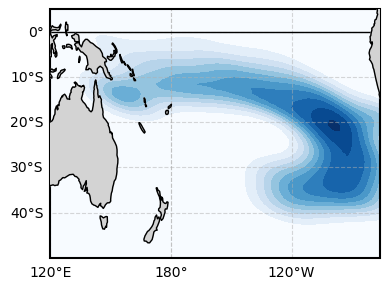

In [60]:
fig, ax = plt.subplots(figsize=(4, 3),
                      subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180, globe=None)})
####### STATICS
ax.add_feature(cfeature.LAND, color='lightgray', zorder=100)
ax.add_feature(cfeature.COASTLINE, linewidth=1., zorder=100)
ax.grid(c='k', linestyle='dashed', alpha=0.2, zorder=4)
ax.set_extent([120, 284, -50, 5], crs=ccrs.PlateCarree())
# ax.set_extent([120, 284, -5, 50], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels={'left': True, 'bottom': True, 'right': False, 'top': False}, 
                  zorder=4, linestyle='--', alpha=0.5)
gl.xlabel_style = {'size': 10, 'color':'k'}  # Longitude labels
gl.ylabel_style = {'size': 10, 'color':'k'}  # Latitude labels
ax.axhline(y=0, color='k', linestyle='-', linewidth=1, zorder=5)
ax.spines['geo'].set_edgecolor('black')
ax.spines['geo'].set_linewidth(1.5)
ax.set_aspect('auto')

####### INITIAL LOCATIONS
# ax.scatter(lon_data[region_idx, 0], lat_data[region_idx, 0], 
#            s=0.5, c='k', marker='o', edgecolor='k', zorder=100,transform=ccrs.PlateCarree())

# #### CONTOURF AND CONTOUR
contourf_plot = traj_list.isel(ens=6).plot.contourf(
    x='lon', y='lat', cmap='Blues', add_colorbar=False, transform=ccrs.PlateCarree(),
    levels=11, vmax=60e-5, vmin=0, alpha=1) # 6

#### TITLE
# plt.title('LENS: Dec', fontsize=11, fontweight='bold', zorder=12, loc='left')
plt.tight_layout()
plt.show()

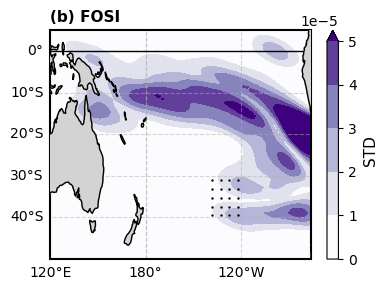

In [65]:
fig, ax = plt.subplots(figsize=(4, 3),
                      subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180, globe=None)})
####### STATICS
ax.add_feature(cfeature.LAND, color='lightgray', zorder=100)
ax.add_feature(cfeature.COASTLINE, linewidth=1., zorder=100)
ax.grid(c='k', linestyle='dashed', alpha=0.2, zorder=4)
ax.set_extent([120, 284, -50, 5], crs=ccrs.PlateCarree())
# ax.set_extent([120, 284, -5, 50], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels={'left': True, 'bottom': True, 'right': False, 'top': False}, 
                  zorder=4, linestyle='--', alpha=0.5)
gl.xlabel_style = {'size': 10, 'color':'k'}  # Longitude labels
gl.ylabel_style = {'size': 10, 'color':'k'}  # Latitude labels
ax.axhline(y=0, color='k', linestyle='-', linewidth=1, zorder=5)
ax.spines['geo'].set_edgecolor('black')
ax.spines['geo'].set_linewidth(1.5)
ax.set_aspect('auto')

####### INITIAL LOCATIONS
ax.scatter(lon_data[region_idx, 0], lat_data[region_idx, 0], 
           s=0.5, c='k', marker='o', edgecolor='k', zorder=100,transform=ccrs.PlateCarree())

# #### CONTOURF AND CONTOUR
contourf_plot = traj_list.std(dim='ens').plot.contourf(
    x='lon', y='lat', cmap='Purples', add_colorbar=True, transform=ccrs.PlateCarree(),
    levels=6, vmax=5e-5, vmin=0, alpha=1) # 6
contourf_plot.colorbar.set_label('STD', fontsize=11)

#### TITLE
plt.title('(b) FOSI', fontsize=11, fontweight='bold', zorder=12, loc='left')
plt.tight_layout()
plt.show()

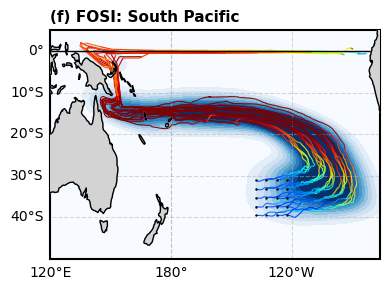

In [21]:
da = da_f
lon_data= lon_trunc_f[:, 0:244]
lat_data= lat_trunc_f[:, 0:244]
z_data= z_trunc_f[:, 0:244]
region_idx = region_idx_f

fig, ax = plt.subplots(figsize=(4, 3),
                      subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180, globe=None)})
####### STATICS
ax.add_feature(cfeature.LAND, color='lightgray', zorder=100)
ax.add_feature(cfeature.COASTLINE, linewidth=1., zorder=100)
ax.grid(c='k', linestyle='dashed', alpha=0.2, zorder=4)
ax.set_extent([120, 284, -50, 5], crs=ccrs.PlateCarree())
# ax.set_extent([120, 284, -5, 50], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels={'left': True, 'bottom': True, 'right': False, 'top': False}, 
                  zorder=4, linestyle='--', alpha=0.5)
gl.xlabel_style = {'size': 10, 'color':'k'}  # Longitude labels
gl.ylabel_style = {'size': 10, 'color':'k'}  # Latitude labels
ax.axhline(y=0, color='k', linestyle='-', linewidth=1, zorder=5)
ax.spines['geo'].set_edgecolor('black')
ax.spines['geo'].set_linewidth(1.5)
ax.set_aspect('auto')

####### INITIAL LOCATIONS
ax.scatter(lon_data[region_idx, 0], lat_data[region_idx, 0], 
           s=0.5, c='k', marker='o', edgecolor='k', zorder=100,transform=ccrs.PlateCarree())

# #### CONTOURF AND CONTOUR
contourf_plot = da.plot.contourf(
    x='lon', y='lat', cmap='Blues', add_colorbar=False, transform=ccrs.PlateCarree(),
    levels=11, vmax=60e-5, vmin=0, alpha=1) # 60 for SH

#### TRAJECTORIES
for i in region_idx[::1]:
    lon = lon_data.isel(trajectory=i).values
    lat = lat_data.isel(trajectory=i).values
    depth = z_data.isel(trajectory=i).values
    points = np.array([lon, lat]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = mcollections.LineCollection(
            segments, cmap='jet', norm=plt.Normalize(0, 25000), 
            linewidth=.8, alpha=1, transform=ccrs.PlateCarree())
    lc.set_array(depth[:-1])
    ax.add_collection(lc)

#### TITLE
plt.title('(f) FOSI: South Pacific', fontsize=11, fontweight='bold', zorder=12, loc='left')
plt.tight_layout()
plt.show()

### Figure 4.

In [5]:
CESMLENS_var = afuncs.LENS_for_regridding() # this is Area

In [6]:
ensemble_members = [0, 65,  32, 85, 61, 90, 80, 68, 73, 49]

In [7]:
file_paths = [f'/glade/derecho/scratch/cassiacai/12032025_subsurface_transport_{i}.nc' for i in ensemble_members]
ds = xr.open_mfdataset(file_paths, combine='nested', concat_dim='ensemble', parallel=True)
ds.coords['ensemble'] = range(10)
subsurface_transport = ds['__xarray_dataarray_variable__'].compute()
lens_subsurface_transport_r = subsurface_transport#.mean(dim='ensemble')

In [8]:
fosi_subsurface_dr = xr.open_dataset(
    '/glade/derecho/scratch/cassiacai/12032025_fosi_subsurface_transport.nc').__xarray_dataarray_variable__

In [9]:
fosi_subsurface_r_dr = xr.DataArray(
    fosi_subsurface_dr.values if hasattr(fosi_subsurface_dr, 'values') else fosi_subsurface_dr,
    dims=['nlat', 'nlon'],  # Use your actual dimension names
    coords={
        'ULONG': lens_subsurface_transport_r.ULONG,
        'ULAT': lens_subsurface_transport_r.ULAT,
        'TLONG': lens_subsurface_transport_r.TLONG,
        'TLAT': lens_subsurface_transport_r.TLAT,
        'time': lens_subsurface_transport_r.time if hasattr(fosi_subsurface_dr, 'time') else existing_dataarray.time
    }
)

In [10]:
fosi_subsurface_transport_ULONG_ULAT = fosi_subsurface_r_dr.assign_coords(
    ULONG=(('nlat', 'nlon'), 
           lens_subsurface_transport_r['ULONG'].values),
    ULAT=(('nlat', 'nlon'), 
           lens_subsurface_transport_r['ULAT'].values))

lens_subsurface_transport_ULONG_ULAT = lens_subsurface_transport_r.assign_coords(
    ULONG=(('nlat', 'nlon'), 
           lens_subsurface_transport_r['ULONG'].values),
    ULAT=(('nlat', 'nlon'), 
           lens_subsurface_transport_r['ULAT'].values))

In [11]:
ds = np.abs(fosi_subsurface_transport_ULONG_ULAT[:,20:65])

In [12]:
def find_wbc_boundary(transport_da, threshold=0.2):
    """
    Find the eastern boundary of the Western Boundary Current (WBC)
    using the rightmost point where the meridional transport gradient
    exceeds a threshold.
    
    Parameters
    ----------
    transport_da : xarray.DataArray
        Meridional transport array with dimensions (nlat, nlon).
        Units should be Sverdrups (Sv).
    threshold : float, default=0.2
        Gradient threshold in Sv per degree longitude.
        
    Returns
    -------
    rightmost_lons : numpy.ndarray
        Longitude of WBC eastern boundary at each latitude.
        NaN where no boundary is found.
    """
    # Calculate absolute zonal gradient
    ds_abs_diff = np.abs(transport_da.diff(dim='nlon'))
    
    # Get shape
    n_lats = ds_abs_diff.sizes['nlat']
    
    # Initialize arrays
    rightmost_indices = np.full(n_lats, np.nan)
    lon_coords = ds_abs_diff.nlon.values
    
    # Find rightmost strong gradient at each latitude
    for lat_idx in range(n_lats):
        grad_vals = ds_abs_diff.isel(nlat=lat_idx).values
        
        # Find where gradient exceeds threshold
        strong_indices = np.where(grad_vals > threshold)[0]
        
        if len(strong_indices) > 0:
            # Take the RIGHTMOST (largest index = easternmost)
            rightmost_indices[lat_idx] = strong_indices[-1]
    
    # Convert indices to longitudes
    rightmost_lons = np.full(n_lats, np.nan)
    
    for lat_idx, idx in enumerate(rightmost_indices):
        if not np.isnan(idx):
            rightmost_lons[lat_idx] = lon_coords[int(idx)]
    
    return rightmost_lons

In [13]:
wbc_lons_fosi = find_wbc_boundary(fosi_subsurface_transport_ULONG_ULAT[:,20:65], threshold=0.2)
wbc_lons_lens0 = find_wbc_boundary(lens_subsurface_transport_ULONG_ULAT[0,:, 20:65], threshold=0.2)
wbc_lons_lens1 = find_wbc_boundary(lens_subsurface_transport_ULONG_ULAT[1,:, 20:65], threshold=0.2)
wbc_lons_lens2 = find_wbc_boundary(lens_subsurface_transport_ULONG_ULAT[2,:, 20:65], threshold=0.2)
wbc_lons_lens3 = find_wbc_boundary(lens_subsurface_transport_ULONG_ULAT[3,:, 20:65], threshold=0.2)
wbc_lons_lens4 = find_wbc_boundary(lens_subsurface_transport_ULONG_ULAT[4,:, 20:65], threshold=0.2)
wbc_lons_lens5 = find_wbc_boundary(lens_subsurface_transport_ULONG_ULAT[5,:, 20:65], threshold=0.2)
wbc_lons_lens6 = find_wbc_boundary(lens_subsurface_transport_ULONG_ULAT[6,:, 20:65], threshold=0.2)
wbc_lons_lens7 = find_wbc_boundary(lens_subsurface_transport_ULONG_ULAT[7,:, 20:65], threshold=0.2)
wbc_lons_lens8 = find_wbc_boundary(lens_subsurface_transport_ULONG_ULAT[8,:, 20:65], threshold=0.2)
wbc_lons_lens9 = find_wbc_boundary(lens_subsurface_transport_ULONG_ULAT[9,:, 20:65], threshold=0.2)

In [64]:
wbc_lons_lens_ls = [wbc_lons_lens0, 
                    wbc_lons_lens1, 
                    wbc_lons_lens2, 
                    wbc_lons_lens3, 
                    wbc_lons_lens4, 
                    wbc_lons_lens5, 
                    wbc_lons_lens6, 
                    wbc_lons_lens7, 
                    wbc_lons_lens8, 
                    wbc_lons_lens9,]


In [178]:
# diff_1deg_wzeros = regrid_SMYLE(lens_subsurface_transport_ULONG_ULAT.mean(dim='ensemble'))
diff_1deg_wzeros = regrid_SMYLE(fosi_subsurface_transport_ULONG_ULAT)

diff_1deg_var = diff_1deg_wzeros.where(diff_1deg_wzeros!=0, np.nan)

regridder = xe.Regridder(diff_1deg_var, CESMLENS_var[:,:], 'nearest_s2d', periodic=True)
regridded_diff = regridder(diff_1deg_var)

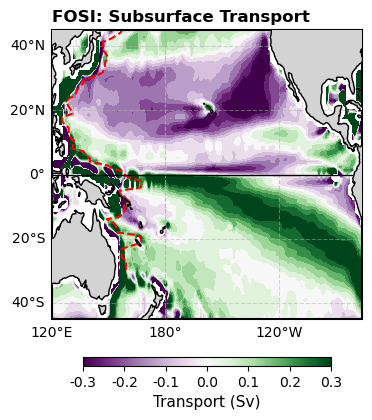

In [179]:
fig, ax = plt.subplots(figsize=(4, 5),
                      subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180, globe=None)})

####### STATICS
ax.add_feature(cfeature.LAND, color='lightgray', zorder=100)
ax.add_feature(cfeature.COASTLINE, linewidth=1., zorder=100)
ax.grid(c='k', linestyle='dashed', alpha=0.2, zorder=4)
ax.set_extent([120, 284, -45, 45], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels={'left': True, 'bottom': True, 'right': False, 'top': False}, 
                  zorder=4, linestyle='--', alpha=0.5)
gl.xlabel_style = {'size': 10, 'color':'k'}  # Longitude labels
gl.ylabel_style = {'size': 10, 'color':'k'}  # Latitude labels
ax.axhline(y=0, color='k', linestyle='-', linewidth=1, zorder=5)
ax.spines['geo'].set_edgecolor('black')
ax.spines['geo'].set_linewidth(1.5)
ax.set_aspect('auto')

# #### CONTOURF AND CONTOUR
contourf_plot = regridded_diff.plot.contourf(
    x='lon', y='lat', cmap='PRGn', add_colorbar=False, transform=ccrs.PlateCarree(),
    vmin=-0.3, vmax=0.3, levels=14, alpha=1)

#### COLORBAR
density_sm = plt.cm.ScalarMappable(cmap='PRGn', norm=plt.Normalize(-0.3, 0.3))
density_sm.set_array([])
density_cbar = plt.colorbar(density_sm, ax=ax, aspect=30, shrink=0.8, pad=0.1, orientation='horizontal')
density_cbar.set_label('Transport (Sv)', fontsize=11)
# tick_values = [-0.5, -0.25, 0., 0.25, 0.5]
tick_values = [-0.3, -0.2, -0.1, 0., 0.1, 0.2, 0.3]
# tick_values = [-0.1, -0.05, 0, 0.05, 0.1]
# tick_values = [-0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15] #[-0.3, -0.2, -0.1, 0., 0.1, 0.2, 0.3]
density_cbar.set_ticks(tick_values)
density_cbar.set_ticklabels([f'{x}' for x in tick_values]) 
density_cbar.ax.tick_params(labelsize=10)
plt.title('')
plt.title('FOSI: Subsurface Transport', fontsize=12, fontweight='bold', zorder=12, loc='left')
plt.plot(wbc_ULONG_ls, 
          lat_val_list_fosi, transform=ccrs.PlateCarree(), c='red', linewidth=1.5, linestyle='dashed')
# plt.plot(np.asarray(wbc_ULONG_ls_full).mean(axis=0), 
#          lat_val_list_fosi, transform=ccrs.PlateCarree(), c='red', linewidth=1.5, linestyle='dashed')

plt.show()

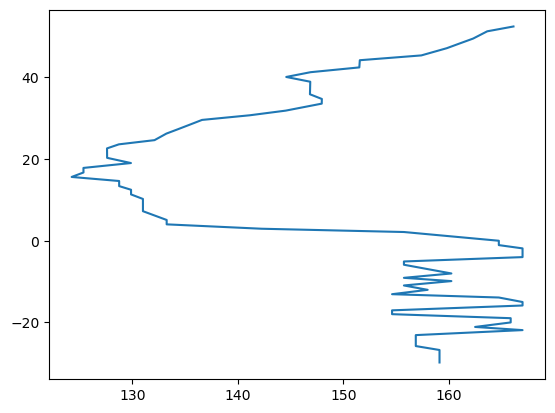

In [165]:
plt.plot(wbc_ULONG_ls, lat_val_list_fosi)


In [155]:
wbc_ac_indx = np.asarray(wbc_lons_fosi)[20:95].astype(int)

In [172]:
wbc_ULONG_ls_full = []

for i in range(10):
    ULONG_ds = ds_integ.ULONG[20:95,:]
    wbc_ac_indx = wbc_lons_lens_ls[i][20:95].astype(int)
    wbc_ULONG_ls = []
    for lat_ind in range(75):
        wbc_ULONG_ls.append(ULONG_ds[lat_ind, wbc_ac_indx[lat_ind]].item())
    wbc_ULONG_ls_full.append(wbc_ULONG_ls)

In [175]:
np.asarray(wbc_ULONG_ls_full).mean(axis=0)

array([159.12500443, 159.12500443, 159.12500443, 158.90000442,
       156.87500437, 156.87500437, 156.87500437, 156.87500437,
       162.83750453, 167.00000465, 167.00000465, 165.87500462,
       154.6250043 , 154.6250043 , 153.50000427, 152.37500424,
       149.22500415, 155.75000433, 158.0000044 , 156.76250436,
       157.10000437, 157.66250439, 160.92500448, 158.0000044 ,
       157.10000437, 155.75000433, 166.88750464, 167.00000465,
       166.66250464, 159.68750444, 157.88750439, 156.53750862,
       151.25002638, 144.83752865, 140.33749924, 137.86244659,
       137.63739288, 135.27464247, 131.33659116, 130.99861037,
       132.12327975, 129.87196617, 129.87091102, 128.74437266,
       128.7425555 , 126.03869284, 125.36044987, 125.35711959,
       131.43703378, 129.85611048, 128.72588889, 127.5922891 ,
       128.71569233, 132.0972289 , 133.22057942, 135.13824006,
       136.15299394, 136.60278983, 143.40032958, 146.80742082,
       147.95559687, 147.96594198, 149.00289603, 147.76

In [156]:
wbc_ULONG_ls = []
ULONG_ds = ds_integ.ULONG[20:95,:]
for lat_ind in range(75):
    wbc_ULONG_ls.append(ULONG_ds[lat_ind, wbc_ac_indx[lat_ind]].item())

array([36, 36, 36, 36, 34, 34, 34, 34, 43, 39, 42, 42, 32, 32, 43, 43, 41,
       32, 35, 33, 37, 33, 37, 35, 33, 33, 43, 43, 43, 41, 41, 37, 33, 21,
       13, 13, 12, 11, 11, 11, 11, 10, 10,  9,  9,  5,  6,  6, 10,  8,  8,
        8,  9, 12, 13, 14, 15, 16, 20, 23, 26, 26, 25, 25, 25, 23, 25, 29,
       29, 34, 36, 37, 38, 39, 41])

In [163]:
wbc_ULONG_ls = []
ULONG_ds = ds_integ.ULONG[20:95,:]
for lat_ind in range(75):
    wbc_ULONG_ls.append(ULONG_ds[lat_ind, wbc_ac_indx[lat_ind]].item())

In [149]:
len(lat_val_list_fosi)

75

In [13]:
diff = lens_subsurface_transport_ULONG_ULAT - fosi_subsurface_transport_ULONG_ULAT

In [14]:
diff_1deg_wzeros = regrid_SMYLE(fosi_subsurface_transport_ULONG_ULAT)
diff_1deg_var = diff_1deg_wzeros.where(diff_1deg_wzeros!=0, np.nan)

regridder = xe.Regridder(diff_1deg_var, CESMLENS_var[:,:], 'nearest_s2d', periodic=True)
regridded_diff = regridder(diff_1deg_var)

In [73]:
wbc_ts_list_fosi = []
int_ts_list_fosi = []
lat_val_list_fosi = []

ds_integ = fosi_subsurface_transport_ULONG_ULAT[:,20:]
for lat_indx in range(20, 60):
    wbc_ac_indx = int(np.asarray(wbc_lons_fosi)[lat_indx])
    wbc_ts = ds_integ[lat_indx, :wbc_ac_indx].dropna(dim='nlon').integrate('ULONG').item()
    int_ts = ds_integ[lat_indx, wbc_ac_indx:].dropna(dim='nlon').integrate('ULONG').item()
    lat_val = ds_integ.ULAT[lat_indx, :].mean()
    lat_val_list_fosi.append(lat_val)
    int_ts_list_fosi.append(int_ts)
    wbc_ts_list_fosi.append(wbc_ts)

ds_integ = fosi_subsurface_transport_ULONG_ULAT[:,20:158]
for lat_indx in range(60, 66):
    wbc_ac_indx = int(np.asarray(wbc_lons_fosi)[lat_indx])
    wbc_ts = ds_integ[lat_indx, :wbc_ac_indx].dropna(dim='nlon').integrate('ULONG').item()
    int_ts = ds_integ[lat_indx, wbc_ac_indx:].dropna(dim='nlon').integrate('ULONG').item()
    lat_val = ds_integ.ULAT[lat_indx, :].mean()
    lat_val_list_fosi.append(lat_val)
    int_ts_list_fosi.append(int_ts)
    wbc_ts_list_fosi.append(wbc_ts)

ds_integ = fosi_subsurface_transport_ULONG_ULAT[:,20:148]
for lat_indx in range(66, 95):
    wbc_ac_indx = int(np.asarray(wbc_lons_fosi)[lat_indx])
    wbc_ts = ds_integ[lat_indx, :wbc_ac_indx].dropna(dim='nlon').integrate('ULONG').item()
    int_ts = ds_integ[lat_indx, wbc_ac_indx:].dropna(dim='nlon').integrate('ULONG').item()
    lat_val = ds_integ.ULAT[lat_indx, :].mean()
    lat_val_list_fosi.append(lat_val)
    int_ts_list_fosi.append(int_ts)
    wbc_ts_list_fosi.append(wbc_ts)

In [66]:
def calc_integrated_subsurface_transport(ds, wbc_lons):
    wbc_ts_list = []
    int_ts_list = []
    lat_val_list = []
    
    ds_integ = ds[:,20:]
    for lat_indx in range(20, 60):
        wbc_ac_indx = int(np.asarray(wbc_lons)[lat_indx])
        wbc_ts = ds_integ[lat_indx, :wbc_ac_indx].dropna(dim='nlon').integrate('ULONG').item()
        int_ts = ds_integ[lat_indx, wbc_ac_indx:].dropna(dim='nlon').integrate('ULONG').item()
        lat_val = ds_integ.ULAT[lat_indx, :].mean()
        lat_val_list.append(lat_val)
        int_ts_list.append(int_ts)
        wbc_ts_list.append(wbc_ts)
    
    ds_integ = ds[:,20:158]
    for lat_indx in range(60, 66):
        wbc_ac_indx = int(np.asarray(wbc_lons_fosi)[lat_indx])
        wbc_ts = ds_integ[lat_indx, :wbc_ac_indx].dropna(dim='nlon').integrate('ULONG').item()
        int_ts = ds_integ[lat_indx, wbc_ac_indx:].dropna(dim='nlon').integrate('ULONG').item()
        lat_val = ds_integ.ULAT[lat_indx, :].mean()
        lat_val_list.append(lat_val)
        int_ts_list.append(int_ts)
        wbc_ts_list.append(wbc_ts)
    
    ds_integ = ds[:,20:148]
    for lat_indx in range(66, 95):
        wbc_ac_indx = int(np.asarray(wbc_lons_fosi)[lat_indx])
        wbc_ts = ds_integ[lat_indx, :wbc_ac_indx].dropna(dim='nlon').integrate('ULONG').item()
        int_ts = ds_integ[lat_indx, wbc_ac_indx:].dropna(dim='nlon').integrate('ULONG').item()
        lat_val = ds_integ.ULAT[lat_indx, :].mean()
        lat_val_list.append(lat_val)
        int_ts_list.append(int_ts)
        wbc_ts_list.append(wbc_ts)

    return wbc_ts_list, int_ts_list, lat_val_list

In [69]:
wbc_ts_ens_ls = []
int_ts_ens_ls = []
lat_val_ens_ls = []
for ens_memb_ind in range(10):
    wbc_ts_ls, int_ts_ls, lat_val_ls = calc_integrated_subsurface_transport(
        lens_subsurface_transport_ULONG_ULAT[ens_memb_ind], 
        wbc_lons_lens_ls[ens_memb_ind])
    wbc_ts_ens_ls.append(wbc_ts_ls)
    int_ts_ens_ls.append(int_ts_ls)
    lat_val_ens_ls.append(lat_val_ls)

In [88]:
wbc_ts_ens_array_mean = np.asarray(wbc_ts_ens_ls).mean(axis=0)
wbc_ts_ens_array_std = np.asarray(wbc_ts_ens_ls).std(axis=0)

int_ts_ens_array_mean = np.asarray(int_ts_ens_ls).mean(axis=0)
int_ts_ens_array_std = np.asarray(int_ts_ens_ls).std(axis=0)

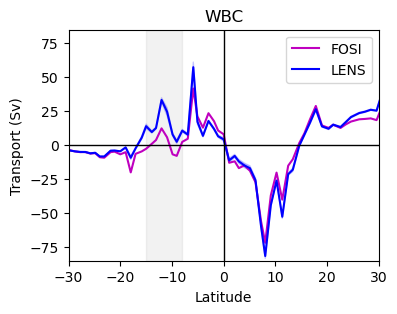

In [110]:
plt.figure(figsize=(4, 3))
plt.plot(lat_val_list_fosi, wbc_ts_list_fosi,c='m', linewidth=1.5, label='FOSI')
plt.plot(lat_val_list_fosi, wbc_ts_ens_array_mean, c='blue', linewidth=1.5, label='LENS')
plt.fill_between(lat_val_list_fosi, 
                 np.array(wbc_ts_ens_array_mean) - np.array(wbc_ts_ens_array_std),
                 np.array(wbc_ts_ens_array_mean) + np.array(wbc_ts_ens_array_std),
                 alpha=0.2, color='blue')
plt.axhline(y=0, c='k', linewidth=1)
# plt.grid(c='k', linestyle='dashed', alpha=0.1, linewidth=0.5)
plt.xlim(-30, 30)
plt.ylim(-85, 85)
plt.axvline(x=0, c='k', linewidth=1)
plt.title('WBC')
plt.ylabel('Transport (Sv)')
plt.xlabel('Latitude')
plt.axvspan(-15, -8, alpha=0.1, color='gray')
plt.legend()
plt.show()

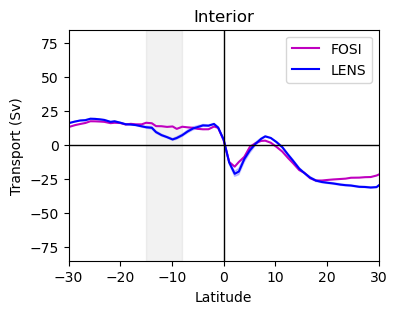

In [109]:
plt.figure(figsize=(4, 3))
plt.plot(lat_val_list_fosi, int_ts_list_fosi,c='m', linewidth=1.5, label='FOSI')
plt.plot(lat_val_list_fosi, int_ts_ens_array_mean, c='blue', linewidth=1.5, label='LENS')
plt.fill_between(lat_val_list_fosi, 
                 np.array(int_ts_ens_array_mean) - np.array(int_ts_ens_array_std),
                 np.array(int_ts_ens_array_mean) + np.array(int_ts_ens_array_std),
                 alpha=0.2, color='blue')
plt.axhline(y=0, c='k', linewidth=1)
# plt.grid(c='k', linestyle='dashed', alpha=0.1, linewidth=0.5)
plt.xlim(-30, 30)
plt.ylim(-85, 85)
plt.axvline(x=0, c='k', linewidth=1)
plt.title('Interior')
plt.ylabel('Transport (Sv)')
plt.xlabel('Latitude')
plt.legend()
plt.axvspan(-15, -8, alpha=0.1, color='gray', label='Southern Tropics')
plt.show()

In [94]:
int_diff = np.asarray(int_ts_ens_array_mean) - np.asarray(int_ts_list_fosi)
wbc_diff = np.asarray(wbc_ts_ens_array_mean) - np.asarray(wbc_ts_list_fosi)

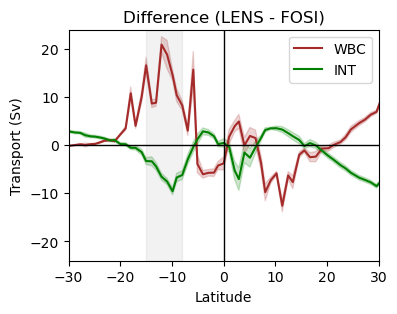

In [107]:
plt.figure(figsize=(4, 3))
plt.plot(lat_val_list_fosi, wbc_diff,c='brown', linewidth=1.5, label='WBC')
plt.plot(lat_val_list_fosi, int_diff,c='green', linewidth=1.5, label='INT')

plt.fill_between(lat_val_list_fosi, 
                 np.array(int_diff) - np.array(int_ts_ens_array_std),
                 np.array(int_diff) + np.array(int_ts_ens_array_std),
                 alpha=0.2, color='green')

plt.fill_between(lat_val_list_fosi, 
                 np.array(wbc_diff) - np.array(wbc_ts_ens_array_std),
                 np.array(wbc_diff) + np.array(wbc_ts_ens_array_std),
                 alpha=0.2, color='brown')

plt.axhline(y=0, c='k', linewidth=1)
# plt.grid(c='k', linestyle='dashed', alpha=0.1, linewidth=0.5)
plt.xlim(-30, 30)
plt.ylim(-24, 24)
plt.axvline(x=0, c='k', linewidth=1)
plt.title('Difference (LENS - FOSI)')
plt.ylabel('Transport (Sv)')
plt.xlabel('Latitude')
plt.legend()
plt.axvspan(-15, -8, alpha=0.1, color='gray', label='Southern Tropics')
plt.show()

In [ ]:
int_ts_mean_list_lens = []
wbc_ts_mean_list_lens = []
int_ts_std_list_lens = []
wbc_ts_std_list_lens = []

ds_integ = lens_subsurface_transport_ULONG_ULAT[:,20:]
for lat_indx in range(20, 60):
    wbc_ac_indx = int(np.asarray(wbc_lons_lens_ls)[lat_indx])
    wbc_ts_mean = ds_integ[lat_indx, :wbc_ac_indx].dropna(dim='nlon').mean(dim='ensemble').integrate('ULONG').item()
    int_ts_mean = ds_integ[lat_indx, wbc_ac_indx:].dropna(dim='nlon').mean(dim='ensemble').integrate('ULONG').item()
    int_ts_list_fosi.append(int_ts)
    wbc_ts_list_fosi.append(wbc_ts)

ds_integ = fosi_subsurface_transport_ULONG_ULAT[:,20:158]
for lat_indx in range(60, 66):
    wbc_ac_indx = int(np.asarray(wbc_lons_fosi)[lat_indx])
    wbc_ts = ds_integ[lat_indx, :wbc_ac_indx].dropna(dim='nlon').integrate('ULONG').item()
    int_ts = ds_integ[lat_indx, wbc_ac_indx:].dropna(dim='nlon').integrate('ULONG').item()
    lat_val = ds_integ.ULAT[lat_indx, :].mean()
    lat_val_list_fosi.append(lat_val)
    int_ts_list_fosi.append(int_ts)
    wbc_ts_list_fosi.append(wbc_ts)

ds_integ = fosi_subsurface_transport_ULONG_ULAT[:,20:148]
for lat_indx in range(66, 95):
    wbc_ac_indx = int(np.asarray(wbc_lons_fosi)[lat_indx])
    wbc_ts = ds_integ[lat_indx, :wbc_ac_indx].dropna(dim='nlon').integrate('ULONG').item()
    int_ts = ds_integ[lat_indx, wbc_ac_indx:].dropna(dim='nlon').integrate('ULONG').item()
    lat_val = ds_integ.ULAT[lat_indx, :].mean()
    lat_val_list_fosi.append(lat_val)
    int_ts_list_fosi.append(int_ts)
    wbc_ts_list_fosi.append(wbc_ts)

(-30.0, 30.0)

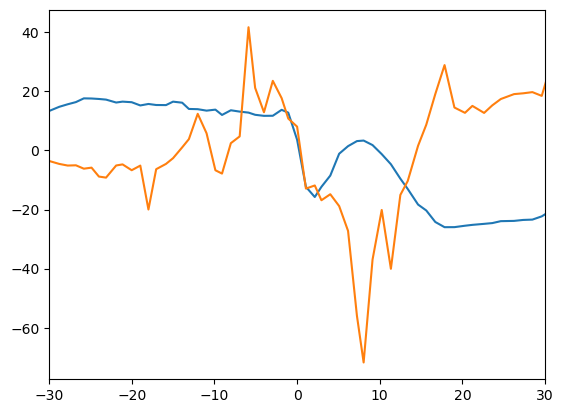

In [58]:
plt.plot(lat_val_list_fosi, int_ts_list_fosi)
plt.plot(lat_val_list_fosi, wbc_ts_list_fosi)
plt.xlim(-30, 30)

In [130]:
print(np.std(int_diff[15:23]))


2.027852133407647


In [129]:
print(np.std(wbc_diff[15:23]))

4.695913691635552


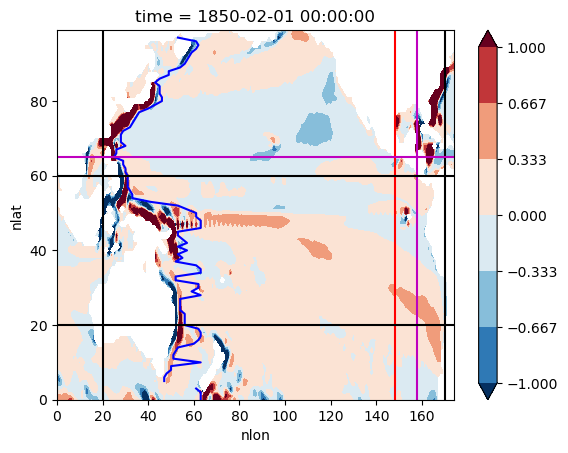

In [53]:
fosi_subsurface_transport_ULONG_ULAT.plot.contourf(vmax=1)
plt.axvline(x=20, c='k')
plt.axvline(x=170, c='k')
plt.axvline(x=148, c='red')
plt.plot(np.asarray(wbc_lons_fosi)+20, np.arange(100), c='blue')
plt.axhline(y=65, c='m')
plt.axvline(x=158, c='m')
plt.axhline(y=60, c='k')
plt.axhline(y=20, c='k')

In [380]:
int_ts_list_fosi = []
wbc_ts_list_fosi = []
lat_val_list_fosi = []
wbc_lons = np.asarray(wbc_lons_fosi)
ds = fosi_subsurface_transport_ULONG_ULAT[:,20:]
for i in range(10,50):
    if wbc_lons[i] == np.nan:
        int_ts_list_fosi.append(np.nan)
        wbc_ts_list_fosi.append(np.nan)
    else:
        int_ts = ds[i, int(wbc_lons[i]):closest_to_285[i]].dropna(dim='nlon').integrate('ULONG').item()
        wbc_ts = ds[i, closest_to_120[i]:int(wbc_lons[i])].dropna(dim='nlon').integrate('ULONG').item()
        lat_val = ds.ULAT[i, closest_to_160[i]:closest_to_285[i]].mean()
        lat_val_list_fosi.append(lat_val)
        int_ts_list_fosi.append(int_ts)
        wbc_ts_list_fosi.append(wbc_ts)

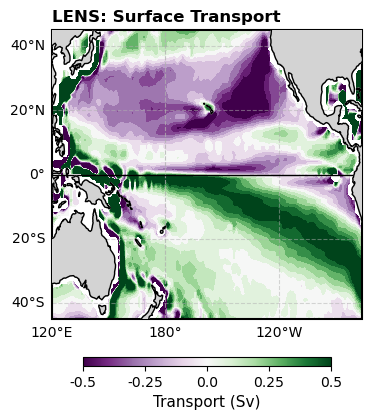

In [15]:
fig, ax = plt.subplots(figsize=(4, 5),
                      subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180, globe=None)})

####### STATICS
ax.add_feature(cfeature.LAND, color='lightgray', zorder=100)
ax.add_feature(cfeature.COASTLINE, linewidth=1., zorder=100)
ax.grid(c='k', linestyle='dashed', alpha=0.2, zorder=4)
ax.set_extent([120, 284, -45, 45], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels={'left': True, 'bottom': True, 'right': False, 'top': False}, 
                  zorder=4, linestyle='--', alpha=0.5)
gl.xlabel_style = {'size': 10, 'color':'k'}  # Longitude labels
gl.ylabel_style = {'size': 10, 'color':'k'}  # Latitude labels
ax.axhline(y=0, color='k', linestyle='-', linewidth=1, zorder=5)
ax.spines['geo'].set_edgecolor('black')
ax.spines['geo'].set_linewidth(1.5)
ax.set_aspect('auto')

# #### CONTOURF AND CONTOUR
contourf_plot = regridded_diff.plot.contourf(
    x='lon', y='lat', cmap='PRGn', add_colorbar=False, transform=ccrs.PlateCarree(),
    vmin=-0.3, vmax=0.3, levels=14, alpha=1)

#### COLORBAR
density_sm = plt.cm.ScalarMappable(cmap='PRGn', norm=plt.Normalize(-0.5, 0.5))
density_sm.set_array([])
density_cbar = plt.colorbar(density_sm, ax=ax, aspect=30, shrink=0.8, pad=0.1, orientation='horizontal')
density_cbar.set_label('Transport (Sv)', fontsize=11)
tick_values = [-0.5, -0.25, 0., 0.25, 0.5]
# tick_values = [-0.3, -0.2, -0.1, 0., 0.1, 0.2, 0.3]
# tick_values = [-0.1, -0.05, 0, 0.05, 0.1]
# tick_values = [-0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15] #[-0.3, -0.2, -0.1, 0., 0.1, 0.2, 0.3]
density_cbar.set_ticks(tick_values)
density_cbar.set_ticklabels([f'{x}' for x in tick_values]) 
density_cbar.ax.tick_params(labelsize=10)
plt.title('')
plt.title('LENS: Surface Transport', fontsize=12, fontweight='bold', zorder=12, loc='left')
plt.show()